## Now that HCF script has been fully developed, implement it here and take a look at outputs.
<b>Author:</b> Meg Fowler <br>
<b>Date:</b> 30 Oct 2020 

In [1]:
# Import libraries 
import comet as cm 
import numpy as np 
import xarray as xr 
import pickle
import pandas as pd
import datetime 
import datetime 
import time 
from ComputeHCF import HCF 
from joblib import Parallel, delayed 

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util


## 1. Read in data

<b>What data do we need?</b> <br>
Vertical profiles of: temperature (T), specific humidity (Q), geopotential height (zg in CESM2, Z3 in other runs), and pressure (P). <br>
In addition, need lowest level temperature, specfic humidity, height, and pressure - so basically T2m, Q2m, PSfc, and 2m height. <br><br>
<b>Units:</b><br>
Temperature --> K <br>
Height      --> m <br>
Sp. Humidity -> kg/kg <br>
Pressure    --> Pa  <br><br>



### 1.1 Read in data from hourly simulation I ran with CESM2

In [3]:
# dataDir = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/hrSim_CONUS/'

# Tpr_file = dataDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.cam.h1.1980_hrT-UTCsel.nc'
# Zpr_file = dataDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.cam.h1.1980_hrZ3-UTCsel.nc'
# Qpr_file = dataDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.cam.h1.1980_hrQ-UTCsel.nc'
# Ppr_file = dataDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.cam.h1.1979-1981_hrP-levels-UTCsel.nc'

# # ----------- Open files -------------
# print('Read in profile of...')
# Tpr = xr.open_dataset(Tpr_file, decode_times=True)
# Tpr['time'] = Tpr.indexes['time'].to_datetimeindex()
# print('.....T')
# Zpr = xr.open_dataset(Zpr_file, decode_times=True)
# Zpr['time'] = Zpr.indexes['time'].to_datetimeindex()
# print('.....Z3')
# Qpr = xr.open_dataset(Qpr_file, decode_times=True)
# Qpr['time'] = Qpr.indexes['time'].to_datetimeindex()
# print('.....Q')
# Ppr = xr.open_dataset(Ppr_file, decode_times=True)
# Ppr['time'] = Ppr.indexes['time'].to_datetimeindex()
# print('.....P')

# # ----------- Isolate 1980 in Ppr -----
# dates1980     = pd.DatetimeIndex(Tpr['time'].values)
# datesPpr      = pd.DatetimeIndex(Ppr['time'].values)
# iTimes        = np.where( (datesPpr>=(dates1980[0])) & (datesPpr<=dates1980[-1]) )[0]

# Ppr_sel       = Ppr.isel(time=iTimes)


This is all a bit easier to work with if everything's in it's own xarray DataSet

In [3]:
# ds_Full = Tpr 
# ds_Full['Qpr'] = (('time','lev','lat','lon'), Qpr.Q)
# ds_Full['Zpr'] = (('time','lev','lat','lon'), Zpr.Z3)
# ds_Full['Ppr'] = (('time','lev','lat','lon'), Ppr_sel.PRESSURE)


In [4]:
# # Pick out 12 UTC only (early morning for most of US)
# ds_utc12 = ds_Full.where( ds_Full.UTC_hr==12.0 , drop=True )


In [5]:
# lat = ds_utc12.lat.values
# lon = ds_utc12.lon.values


In [6]:
# # Isolate UTC times 
# UTC_hr_CESM2  = ds_utc12.UTC_hr.values
# UTC_day_CESM2 = ds_utc12.UTC_day.values
# UTC_mon_CESM2 = ds_utc12.UTC_mon.values
# UTC_yr_CESM2  = ds_utc12.UTC_yr.values

### 1.2 Read in 3-hrly data from Isla's run with CAM6+CLM4.5

In [2]:
# Set up strings used to define/access each file 
dataDir    = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/3hrSim_CAM6-CLM45/'

fileStart  = 'f.e21.FHIST.f09_f09.cesm2_cam6_clm4p5.001.cam.h4.'
profileEnd = '_conusAllTimes-VertProfiles.nc'
pressEnd   = '_conus-Pressure-UTCtimes.nc'

years = np.arange(1980,1983).astype(str)

# Read in yearly files 
for iYr in range(len(years)): 
    # Set up file names 
    fileName_profile = dataDir+fileStart+years[iYr]+profileEnd
    fileName_press   = dataDir+fileStart+years[iYr]+pressEnd
    
    # Open files and save to larger arrays 
    with xr.open_dataset(fileName_profile, decode_times=True) as profileDS:
        profileDS['time'] = profileDS.indexes['time'].to_datetimeindex()
        profileDS
        
        if iYr==0:
            fullDS_profiles = profileDS
        else: 
            fullDS_profiles = xr.concat([fullDS_profiles, profileDS], dim='time')

            
    with xr.open_dataset(fileName_press, decode_times=True) as pressDS:
        pressDS['time'] = pressDS.indexes['time'].to_datetimeindex()
        
        if iYr==0:
            fullDS_pressure = pressDS
        else: 
            fullDS_pressure = xr.concat([fullDS_pressure,pressDS], dim='time')
    
    print('Done with reading in files for year %s' % years[iYr])


<ipython-input-2-218dcec84f2e>:18: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  profileDS['time'] = profileDS.indexes['time'].to_datetimeindex()
<ipython-input-2-218dcec84f2e>:28: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  pressDS['time'] = pressDS.indexes['time'].to_datetimeindex()


Done with reading in files for year 1980
Done with reading in files for year 1981
Done with reading in files for year 1982


In [3]:
ds_CLM45 = fullDS_profiles
ds_CLM45['PRESSURE'] = (('time','lev','lat','lon'), fullDS_pressure.PRESSURE)
ds_CLM45['UTC_hr']   = (('time'), fullDS_pressure.UTC_hr)
ds_CLM45['UTC_day']  = (('time'), fullDS_pressure.UTC_day)
ds_CLM45['UTC_mon']  = (('time'), fullDS_pressure.UTC_mon)
ds_CLM45['UTC_yr']   = (('time'), fullDS_pressure.UTC_yr)

# # ----------- Isolate 1980 for testing -----
# i1980        = np.where(ds_CLM45.UTC_yr==1980)[0]
# ds1980_CLM45 = ds_CLM45.isel(time=i1980)


In [4]:
# Pick out 12 UTC only (early morning for most of US)
ds_utc12_CLM45 = ds_CLM45.where( ds_CLM45.UTC_hr==12.0, drop=True )


In [5]:
# Isolate UTC times 
UTC_hr_CLM45  = ds_utc12_CLM45.UTC_hr.values
UTC_day_CLM45 = ds_utc12_CLM45.UTC_day.values
UTC_mon_CLM45 = ds_utc12_CLM45.UTC_mon.values
UTC_yr_CLM45  = ds_utc12_CLM45.UTC_yr.values


In [6]:
# Also get lat and lon
lat = ds_utc12_CLM45.lat.values
lon = ds_utc12_CLM45.lon.values


### 1.3 Read in 3-hrly data from Isla's run with CAM6+CLM5 (for consistency, would rather use this)

In [7]:
# Set up strings used to define/access each file 
dataDir    = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/3hrSim_CAM6-CLM5/'

fileStart  = 'f.e21.FHIST.f09_f09.cesm2_cam6_clm5.001.cam.h4.'
profileEnd = '_conusAllTimes-VertProfiles.nc'
pressEnd   = '_conus-Pressure-UTCtimes.nc'

years = np.arange(1980,1983).astype(str)

# Read in yearly files 
for iYr in range(len(years)): 
    # Set up file names 
    fileName_profile = dataDir+fileStart+years[iYr]+profileEnd
    fileName_press   = dataDir+fileStart+years[iYr]+pressEnd
    
    # Open files and save to larger arrays 
    with xr.open_dataset(fileName_profile, decode_times=True) as profileDS:
        profileDS['time'] = profileDS.indexes['time'].to_datetimeindex()
        profileDS
        
        if iYr==0:
            fullDS_profiles = profileDS
        else: 
            fullDS_profiles = xr.concat([fullDS_profiles, profileDS], dim='time')

            
    with xr.open_dataset(fileName_press, decode_times=True) as pressDS:
        pressDS['time'] = pressDS.indexes['time'].to_datetimeindex()
        
        if iYr==0:
            fullDS_pressure = pressDS
        else: 
            fullDS_pressure = xr.concat([fullDS_pressure,pressDS], dim='time')
    
    print('Done with reading in files for year %s' % years[iYr])


<ipython-input-7-ebf64350df9a>:18: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  profileDS['time'] = profileDS.indexes['time'].to_datetimeindex()
<ipython-input-7-ebf64350df9a>:28: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  pressDS['time'] = pressDS.indexes['time'].to_datetimeindex()


Done with reading in files for year 1980
Done with reading in files for year 1981
Done with reading in files for year 1982


In [8]:
ds_CLM5 = fullDS_profiles
ds_CLM5['PRESSURE'] = (('time','lev','lat','lon'), fullDS_pressure.PRESSURE)
ds_CLM5['UTC_hr'] = (('time'), fullDS_pressure.UTC_hr)
ds_CLM5['UTC_day'] = (('time'), fullDS_pressure.UTC_day)
ds_CLM5['UTC_mon'] = (('time'), fullDS_pressure.UTC_mon)
ds_CLM5['UTC_yr'] = (('time'), fullDS_pressure.UTC_yr)


In [9]:
# Pick out 12 UTC only (early morning for most of US)
ds_utc12_CLM5 = ds_CLM5.where( ds_CLM5.UTC_hr==12.0, drop=True )

# Isolate UTC times 
UTC_hr_CLM5  = ds_utc12_CLM5.UTC_hr.values
UTC_day_CLM5 = ds_utc12_CLM5.UTC_day.values
UTC_mon_CLM5 = ds_utc12_CLM5.UTC_mon.values
UTC_yr_CLM5  = ds_utc12_CLM5.UTC_yr.values


## 2. Compute HCF for each grid point. 

Do note though that this is not the most *efficient* code, by any means. There may be ways to speed this up though, and parallel processing should certainly be do-able as well, since each profile is treated independently. 

In [1]:
# # ------------------------------------------
# # Compute for each day and lat/lon point
# #   Takes 35-40 minutes to run for one year
# # ------------------------------------------

# # Define variable names 
# Tname = 'T'
# Qname = 'Qpr'
# Zname = 'Zpr'
# Pname = 'Ppr'

# # Number of levels to worry about in actual "sounding"
# nLev  = len(ds_utc12.lev)

# # Define dimensions 
# nLat  = len(ds_utc12.lat)
# nLon  = len(ds_utc12.lon)
# nTime = len(ds_utc12.time)

# # Define empty arrays to save things into 
# TBM_all     = np.full([nTime,nLat,nLon], np.nan)
# BCLH_all    = np.full([nTime,nLat,nLon], np.nan)
# BCLP_all    = np.full([nTime,nLat,nLon], np.nan)
# TDEF_all    = np.full([nTime,nLat,nLon], np.nan)

# TRAN_H_all  = np.full([nTime,nLat,nLon], np.nan)
# TRAN_P_all  = np.full([nTime,nLat,nLon], np.nan)
# TRAN_T_all  = np.full([nTime,nLat,nLon], np.nan)
# SHDEF_M_all = np.full([nTime,nLat,nLon], np.nan)
# LHDEF_M_all = np.full([nTime,nLat,nLon], np.nan)
# EADV_M_all  = np.full([nTime,nLat,nLon], np.nan)

# # Time how long this takes... 
# t_start     = time.time()

# for iLat in range(nLat):
#     for iLon in range(nLon):
#         for iT in range(nTime):
            
#             # Pick out specific point and time period 
#             DF = ds_utc12.isel(lat=iLat,lon=iLon,time=iT).to_dataframe()
            
#             # Flip order of levels so that surface comes first (required for function)
#             DF = DF.reindex(index=DF.index[::-1])
            
#             # Compute HCF variables
#             TBM_all[iT,iLat,iLon],BCLH_all[iT,iLat,iLon],BCLP_all[iT,iLat,iLon],TDEF_all[iT,iLat,iLon],TRAN_H_all[iT,iLat,iLon],TRAN_P_all[iT,iLat,iLon],TRAN_T_all[iT,iLat,iLon],SHDEF_M_all[iT,iLat,iLon],LHDEF_M_all[iT,iLat,iLon], EADV_M_all[iT,iLat,iLon] = HCF(DF, 
#                                                                       Tname, 
#                                                                       Qname, 
#                                                                       Zname, 
#                                                                       Pname, 
#                                                                       nLev) 
                                                                      
#     print('Done with lat %i of %i ' % (iLat, nLat))
        

# print('Time elapsed for all points and times: %.3f sec' % (time.time() - t_start))


Since computing HCF at each grid point and day can take so long, it's best to only run the above loops once. From there, you can save the output for each variable into a pickle file (a bit easier to work with in python than a full netCDF file or anything like that. <br> 
Alternatively, in the implementation used here, you can first place all the variables into a single xarray dataset again, and save that to a netCDF file. 

In [20]:
# # ---------------------------------------
# # Create xr dataset from variables above 
# # ---------------------------------------

# # First set missing values to -9999
# missingValue  = -9999

# TBM_write     = np.copy(TBM_all)
# BCLH_write    = np.copy(BCLH_all)
# BCLP_write    = np.copy(BCLP_all)
# TDEF_write    = np.copy(TDEF_all)
# TRAN_H_write  = np.copy(TRAN_H_all)
# TRAN_P_write  = np.copy(TRAN_P_all)
# TRAN_T_write  = np.copy(TRAN_T_all)
# SHDEF_M_write = np.copy(SHDEF_M_all)
# LHDEF_M_write = np.copy(LHDEF_M_all)
# EADV_M_write  = np.copy(EADV_M_all)

# TBM_write    [np.isnan(TBM_all)    ==True] = missingValue
# BCLH_write   [np.isnan(BCLH_all)   ==True] = missingValue
# BCLP_write   [np.isnan(BCLP_all)   ==True] = missingValue
# TDEF_write   [np.isnan(TDEF_all)   ==True] = missingValue
# TRAN_H_write [np.isnan(TRAN_H_all) ==True] = missingValue
# TRAN_P_write [np.isnan(TRAN_P_all) ==True] = missingValue
# TRAN_T_write [np.isnan(TRAN_T_all) ==True] = missingValue
# SHDEF_M_write[np.isnan(SHDEF_M_all)==True] = missingValue
# LHDEF_M_write[np.isnan(LHDEF_M_all)==True] = missingValue
# EADV_M_write [np.isnan(EADV_M_all) ==True] = missingValue
 
# HCF_ds = xr.Dataset({
#     'TBM': xr.DataArray(
#                 data   = TBM_write,   # enter data here
#                 dims   = ['time','lat','lon'],
#                 coords = {'time': ds_utc12.time.values, 'lat':lat, 'lon': lon},
#                 attrs  = {
#                     '_FillValue': missingValue,
#                     'units'     : 'K',
#                     'LongName'  : 'Buoyant mixing potential temperature (convective threshold)'
#                     }
#                 ),
#     'BCLH': xr.DataArray(
#                 data   = BCLH_write,   # enter data here
#                 dims   = ['time','lat','lon'],
#                 coords = {'time': ds_utc12.time.values, 'lat':lat, 'lon': lon},
#                 attrs  = {
#                     '_FillValue': missingValue,
#                     'units'     : 'm',
#                     'LongName'  : 'Height above ground of convective threshold'
#                     }
#                 ),
#     'BCLP': xr.DataArray(
#             data   = BCLP_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'Pa',
#                 'LongName'  : 'Pressure of convective threshold'
#                 }
#             ),
#     'TDEF': xr.DataArray(
#             data   = TDEF_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'K',
#                 'LongName'  : 'Potential temperature deficit needed to initiate convection'
#                 }
#             ),
#     'TRAN_H': xr.DataArray(
#             data   = TRAN_H_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'm',
#                 'LongName'  : 'Energy transition height'
#                 }
#             ),
#     'TRAN_P': xr.DataArray(
#             data   = TRAN_P_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'Pa',
#                 'LongName'  : 'Energy transition pressure'
#                 }
#             ),
#     'TRAN_T': xr.DataArray(
#             data   = TRAN_T_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'K',
#                 'LongName'  : 'Energy transition temperature'
#                 }
#             ),
#     'SHDEF_M': xr.DataArray(
#             data   = SHDEF_M_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'J/m2',
#                 'LongName'  : 'Sensible heat deficit of mixed layer'
#                 }
#             ),
#     'LHDEF_M': xr.DataArray(
#             data   = LHDEF_M_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'J/m2',
#                 'LongName'  : 'Latent heat deficit of mixed layer'
#                 }
#             ),
#     'EADV_M': xr.DataArray(
#             data   = EADV_M_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : '-',
#                 'LongName'  : 'Energy advantage of mixed layer'
#                 }
#             )
#     } )

# # -------------------
# # Save to netCDF 
# # -------------------

# savePath = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/HCFvariables_1980.nc'
# HCF_ds.to_netcdf(savePath, mode='w')


Now we can just load in the netCDF file created above (or more files as well, as necessary):

In [11]:
# # Read in netCDF file containing all the HCF variables previously computed... 
# filePath = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/HCFvariables_1980.nc'
# HCFvars  = xr.open_dataset(filePath, decode_times=True)


### 2.1 Compute HCF for CAM6+CLM4.5 simulation

In [10]:
# When converting to a dataframe, need to only have relevent dimension included in dataset. Otherwise,
#   the function to convert to DF will create extra entries along dimensions that things like temperature and 
#   humidity don't depend on, breaking the below HCF calculation cell. 

ds_utc12_CLM45 = ds_utc12_CLM45.drop('time_bnds')  # Want to get rid of nbnd dimension 

# Want to also drop ilev dimension
ds_utc12_CLM45 = ds_utc12_CLM45.drop('hyai')
ds_utc12_CLM45 = ds_utc12_CLM45.drop('hybi') 
ds_utc12_CLM45 = ds_utc12_CLM45.drop('ilev')

In [2]:
# # ------------------------------------------
# # Compute for each day and lat/lon point
# #   Takes 35-40 minutes to run for one year
# # ------------------------------------------

# # Define variable names 
# Tname = 'T'
# Qname = 'Q'
# Zname = 'Z3'
# Pname = 'PRESSURE'

# # Number of levels to worry about in actual "sounding"
# nLev  = len(ds_utc12_CLM45.lev)

# # Define dimensions 
# nLat  = len(ds_utc12_CLM45.lat)
# nLon  = len(ds_utc12_CLM45.lon)
# nTime = len(ds_utc12_CLM45.time)

# # Define empty arrays to save things into 
# TBM_all     = np.full([nTime,nLat,nLon], np.nan)
# BCLH_all    = np.full([nTime,nLat,nLon], np.nan)
# BCLP_all    = np.full([nTime,nLat,nLon], np.nan)
# TDEF_all    = np.full([nTime,nLat,nLon], np.nan)

# TRAN_H_all  = np.full([nTime,nLat,nLon], np.nan)
# TRAN_P_all  = np.full([nTime,nLat,nLon], np.nan)
# TRAN_T_all  = np.full([nTime,nLat,nLon], np.nan)
# SHDEF_M_all = np.full([nTime,nLat,nLon], np.nan)
# LHDEF_M_all = np.full([nTime,nLat,nLon], np.nan)
# EADV_M_all  = np.full([nTime,nLat,nLon], np.nan)

# # Time how long this takes... 
# t_start     = time.time()

# for iLat in range(nLat):
#     for iLon in range(nLon):
#         for iT in range(nTime):

#             # Pick out specific point and time period 
#             DF = ds_utc12_CLM45.isel(lat=iLat,lon=iLon,time=iT).to_dataframe()

#             # Flip order of levels so that surface comes first (required for function)
#             DF = DF.reindex(index=DF.index[::-1])

#             # Compute HCF variables
#             TBM_all[iT,iLat,iLon],BCLH_all[iT,iLat,iLon],BCLP_all[iT,iLat,iLon],TDEF_all[iT,iLat,iLon],TRAN_H_all[iT,iLat,iLon],TRAN_P_all[iT,iLat,iLon],TRAN_T_all[iT,iLat,iLon],SHDEF_M_all[iT,iLat,iLon],LHDEF_M_all[iT,iLat,iLon], EADV_M_all[iT,iLat,iLon] = HCF(DF, 
#                                                                       Tname, 
#                                                                       Qname, 
#                                                                       Zname, 
#                                                                       Pname, 
#                                                                       nLev) 

#     print('Done with lat %i of %i ' % (iLat, nLat))


# print('Time elapsed for all points and times: %.3f sec' % (time.time() - t_start))



In [11]:
# # Set lat and lon as well: 
# lat = ds_utc12_CLM45.lat.values
# lon = ds_utc12_CLM45.lon.values

In [12]:
# # ---------------------------------------
# # Create xr dataset from variables above 
# # ---------------------------------------

# # First set missing values to -9999
# missingValue  = -9999

# TBM_write     = np.copy(TBM_all)
# BCLH_write    = np.copy(BCLH_all)
# BCLP_write    = np.copy(BCLP_all)
# TDEF_write    = np.copy(TDEF_all)
# TRAN_H_write  = np.copy(TRAN_H_all)
# TRAN_P_write  = np.copy(TRAN_P_all)
# TRAN_T_write  = np.copy(TRAN_T_all)
# SHDEF_M_write = np.copy(SHDEF_M_all)
# LHDEF_M_write = np.copy(LHDEF_M_all)
# EADV_M_write  = np.copy(EADV_M_all)

# TBM_write    [np.isnan(TBM_all)    ==True] = missingValue
# BCLH_write   [np.isnan(BCLH_all)   ==True] = missingValue
# BCLP_write   [np.isnan(BCLP_all)   ==True] = missingValue
# TDEF_write   [np.isnan(TDEF_all)   ==True] = missingValue
# TRAN_H_write [np.isnan(TRAN_H_all) ==True] = missingValue
# TRAN_P_write [np.isnan(TRAN_P_all) ==True] = missingValue
# TRAN_T_write [np.isnan(TRAN_T_all) ==True] = missingValue
# SHDEF_M_write[np.isnan(SHDEF_M_all)==True] = missingValue
# LHDEF_M_write[np.isnan(LHDEF_M_all)==True] = missingValue
# EADV_M_write [np.isnan(EADV_M_all) ==True] = missingValue
 
# HCF_ds = xr.Dataset({
#     'TBM': xr.DataArray(
#                 data   = TBM_write,   # enter data here
#                 dims   = ['time','lat','lon'],
#                 coords = {'time': ds_utc12_CLM45.time.values, 'lat':lat, 'lon': lon},
#                 attrs  = {
#                     '_FillValue': missingValue,
#                     'units'     : 'K',
#                     'LongName'  : 'Buoyant mixing potential temperature (convective threshold)'
#                     }
#                 ),
#     'BCLH': xr.DataArray(
#                 data   = BCLH_write,   # enter data here
#                 dims   = ['time','lat','lon'],
#                 coords = {'time': ds_utc12_CLM45.time.values, 'lat':lat, 'lon': lon},
#                 attrs  = {
#                     '_FillValue': missingValue,
#                     'units'     : 'm',
#                     'LongName'  : 'Height above ground of convective threshold'
#                     }
#                 ),
#     'BCLP': xr.DataArray(
#             data   = BCLP_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM45.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'Pa',
#                 'LongName'  : 'Pressure of convective threshold'
#                 }
#             ),
#     'TDEF': xr.DataArray(
#             data   = TDEF_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM45.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'K',
#                 'LongName'  : 'Potential temperature deficit needed to initiate convection'
#                 }
#             ),
#     'TRAN_H': xr.DataArray(
#             data   = TRAN_H_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM45.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'm',
#                 'LongName'  : 'Energy transition height'
#                 }
#             ),
#     'TRAN_P': xr.DataArray(
#             data   = TRAN_P_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM45.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'Pa',
#                 'LongName'  : 'Energy transition pressure'
#                 }
#             ),
#     'TRAN_T': xr.DataArray(
#             data   = TRAN_T_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM45.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'K',
#                 'LongName'  : 'Energy transition temperature'
#                 }
#             ),
#     'SHDEF_M': xr.DataArray(
#             data   = SHDEF_M_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM45.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'J/m2',
#                 'LongName'  : 'Sensible heat deficit of mixed layer'
#                 }
#             ),
#     'LHDEF_M': xr.DataArray(
#             data   = LHDEF_M_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM45.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'J/m2',
#                 'LongName'  : 'Latent heat deficit of mixed layer'
#                 }
#             ),
#     'EADV_M': xr.DataArray(
#             data   = EADV_M_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM45.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : '-',
#                 'LongName'  : 'Energy advantage of mixed layer'
#                 }
#             )
#     } )

# # -------------------
# # Save to netCDF 
# # -------------------

# savePath = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/HCFvariables-CAM6CLM4p5_1980-1982.nc'
# HCF_ds.to_netcdf(savePath, mode='w')



In [11]:
# Read in netCDF file containing all the HCF variables previously computed... 
filePath = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/HCFvariables-CAM6CLM4p5_1980-1982.nc'
HCFvars_CLM45  = xr.open_dataset(filePath, decode_times=True)


### 2.2 Compute for CAM6+CLM5 run from Isla

In [12]:
# When converting to a dataframe, need to only have relevent dimension included in dataset. Otherwise,
#   the function to convert to DF will create extra entries along dimensions that things like temperature and 
#   humidity don't depend on, breaking the below HCF calculation cell. 

ds_utc12_CLM5 = ds_utc12_CLM5.drop('time_bnds')  # Want to get rid of nbnd dimension 

# Want to also drop ilev dimension
ds_utc12_CLM5 = ds_utc12_CLM5.drop('hyai')
ds_utc12_CLM5 = ds_utc12_CLM5.drop('hybi') 
ds_utc12_CLM5 = ds_utc12_CLM5.drop('ilev')

# Set lat and lon as well: 
lat = ds_utc12_CLM5.lat.values
lon = ds_utc12_CLM5.lon.values


In [3]:
# # ------------------------------------------
# # Compute for each day and lat/lon point
# #   Takes 35-40 minutes to run for one year
# # ------------------------------------------

# # Define variable names 
# Tname = 'T'
# Qname = 'Q'
# Zname = 'Z3'
# Pname = 'PRESSURE'

# # Number of levels to worry about in actual "sounding"
# nLev  = len(ds_utc12_CLM5.lev)

# # Define dimensions 
# nLat  = len(ds_utc12_CLM5.lat)
# nLon  = len(ds_utc12_CLM5.lon)
# nTime = len(ds_utc12_CLM5.time)

# # Define empty arrays to save things into 
# TBM_all     = np.full([nTime,nLat,nLon], np.nan)
# BCLH_all    = np.full([nTime,nLat,nLon], np.nan)
# BCLP_all    = np.full([nTime,nLat,nLon], np.nan)
# TDEF_all    = np.full([nTime,nLat,nLon], np.nan)

# TRAN_H_all  = np.full([nTime,nLat,nLon], np.nan)
# TRAN_P_all  = np.full([nTime,nLat,nLon], np.nan)
# TRAN_T_all  = np.full([nTime,nLat,nLon], np.nan)
# SHDEF_M_all = np.full([nTime,nLat,nLon], np.nan)
# LHDEF_M_all = np.full([nTime,nLat,nLon], np.nan)
# EADV_M_all  = np.full([nTime,nLat,nLon], np.nan)

# # Time how long this takes... 
# t_start     = time.time()

# for iLat in range(nLat):
#     for iLon in range(nLon):
#         for iT in range(nTime):

#             # Pick out specific point and time period 
#             DF = ds_utc12_CLM5.isel(lat=iLat,lon=iLon,time=iT).to_dataframe()

#             # Flip order of levels so that surface comes first (required for function)
#             DF = DF.reindex(index=DF.index[::-1])

#             # Compute HCF variables
#             TBM_all[iT,iLat,iLon],BCLH_all[iT,iLat,iLon],BCLP_all[iT,iLat,iLon],TDEF_all[iT,iLat,iLon],TRAN_H_all[iT,iLat,iLon],TRAN_P_all[iT,iLat,iLon],TRAN_T_all[iT,iLat,iLon],SHDEF_M_all[iT,iLat,iLon],LHDEF_M_all[iT,iLat,iLon], EADV_M_all[iT,iLat,iLon] = HCF(DF, 
#                                                                       Tname, 
#                                                                       Qname, 
#                                                                       Zname, 
#                                                                       Pname, 
#                                                                       nLev) 

#     print('Done with lat %i of %i ' % (iLat, nLat))


# print('Time elapsed for all points and times: %.3f sec' % (time.time() - t_start))


In [50]:
# # ---------------------------------------
# # Create xr dataset from variables above 
# # ---------------------------------------

# # First set missing values to -9999
# missingValue  = -9999

# TBM_write     = np.copy(TBM_all)
# BCLH_write    = np.copy(BCLH_all)
# BCLP_write    = np.copy(BCLP_all)
# TDEF_write    = np.copy(TDEF_all)
# TRAN_H_write  = np.copy(TRAN_H_all)
# TRAN_P_write  = np.copy(TRAN_P_all)
# TRAN_T_write  = np.copy(TRAN_T_all)
# SHDEF_M_write = np.copy(SHDEF_M_all)
# LHDEF_M_write = np.copy(LHDEF_M_all)
# EADV_M_write  = np.copy(EADV_M_all)

# TBM_write    [np.isnan(TBM_all)    ==True] = missingValue
# BCLH_write   [np.isnan(BCLH_all)   ==True] = missingValue
# BCLP_write   [np.isnan(BCLP_all)   ==True] = missingValue
# TDEF_write   [np.isnan(TDEF_all)   ==True] = missingValue
# TRAN_H_write [np.isnan(TRAN_H_all) ==True] = missingValue
# TRAN_P_write [np.isnan(TRAN_P_all) ==True] = missingValue
# TRAN_T_write [np.isnan(TRAN_T_all) ==True] = missingValue
# SHDEF_M_write[np.isnan(SHDEF_M_all)==True] = missingValue
# LHDEF_M_write[np.isnan(LHDEF_M_all)==True] = missingValue
# EADV_M_write [np.isnan(EADV_M_all) ==True] = missingValue
 
# HCF_ds = xr.Dataset({
#     'TBM': xr.DataArray(
#                 data   = TBM_write,   # enter data here
#                 dims   = ['time','lat','lon'],
#                 coords = {'time': ds_utc12_CLM5.time.values, 'lat':lat, 'lon': lon},
#                 attrs  = {
#                     '_FillValue': missingValue,
#                     'units'     : 'K',
#                     'LongName'  : 'Buoyant mixing potential temperature (convective threshold)'
#                     }
#                 ),
#     'BCLH': xr.DataArray(
#                 data   = BCLH_write,   # enter data here
#                 dims   = ['time','lat','lon'],
#                 coords = {'time': ds_utc12_CLM5.time.values, 'lat':lat, 'lon': lon},
#                 attrs  = {
#                     '_FillValue': missingValue,
#                     'units'     : 'm',
#                     'LongName'  : 'Height above ground of convective threshold'
#                     }
#                 ),
#     'BCLP': xr.DataArray(
#             data   = BCLP_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM5.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'Pa',
#                 'LongName'  : 'Pressure of convective threshold'
#                 }
#             ),
#     'TDEF': xr.DataArray(
#             data   = TDEF_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM5.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'K',
#                 'LongName'  : 'Potential temperature deficit needed to initiate convection'
#                 }
#             ),
#     'TRAN_H': xr.DataArray(
#             data   = TRAN_H_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM5.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'm',
#                 'LongName'  : 'Energy transition height'
#                 }
#             ),
#     'TRAN_P': xr.DataArray(
#             data   = TRAN_P_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM5.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'Pa',
#                 'LongName'  : 'Energy transition pressure'
#                 }
#             ),
#     'TRAN_T': xr.DataArray(
#             data   = TRAN_T_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM5.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'K',
#                 'LongName'  : 'Energy transition temperature'
#                 }
#             ),
#     'SHDEF_M': xr.DataArray(
#             data   = SHDEF_M_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM5.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'J/m2',
#                 'LongName'  : 'Sensible heat deficit of mixed layer'
#                 }
#             ),
#     'LHDEF_M': xr.DataArray(
#             data   = LHDEF_M_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM5.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : 'J/m2',
#                 'LongName'  : 'Latent heat deficit of mixed layer'
#                 }
#             ),
#     'EADV_M': xr.DataArray(
#             data   = EADV_M_write,   # enter data here
#             dims   = ['time','lat','lon'],
#             coords = {'time': ds_utc12_CLM5.time.values, 'lat':lat, 'lon': lon},
#             attrs  = {
#                 '_FillValue': missingValue,
#                 'units'     : '-',
#                 'LongName'  : 'Energy advantage of mixed layer'
#                 }
#             )
#     } )

# # -------------------
# # Save to netCDF 
# # -------------------

# savePath = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/HCFvariables-CAM6CLM5-islarun_1980-1982.nc'
# HCF_ds.to_netcdf(savePath, mode='w')


In [13]:
# Read in netCDF file containing all the HCF variables previously computed... 
filePath = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/HCFvariables-CAM6CLM5-islarun_1980-1982.nc'
HCFvars_CLM5  = xr.open_dataset(filePath, decode_times=True)


In [168]:
HCFvars_CLM5

<xarray.Dataset>
Dimensions:  (lat: 43, lon: 65, time: 1095)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01T12:00:00 ... 1982-12-31T12:00:00
  * lat      (lat) float64 20.26 21.2 22.15 23.09 ... 57.02 57.96 58.9 59.84
  * lon      (lon) float64 220.0 221.2 222.5 223.8 ... 296.2 297.5 298.8 300.0
Data variables:
    TBM      (time, lat, lon) float64 294.2 294.2 294.3 ... 265.0 265.2 265.4
    BCLH     (time, lat, lon) float64 ...
    BCLP     (time, lat, lon) float64 ...
    TDEF     (time, lat, lon) float64 ...
    TRAN_H   (time, lat, lon) float64 ...
    TRAN_P   (time, lat, lon) float64 ...
    TRAN_T   (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    SHDEF_M  (time, lat, lon) float64 ...
    LHDEF_M  (time, lat, lon) float64 ...
    EADV_M   (time, lat, lon) float64 ...

## 3. Now plot some of these variables 

In [14]:
# Pull out dimensions
lat  = HCFvars_CLM5.lat.values
lon  = HCFvars_CLM5.lon.values
time = HCFvars_CLM5.time.values


In [15]:
# Get summer values only
iJJA_CLM5   = np.where( (UTC_mon_CLM5>=6) & (UTC_mon_CLM5<=8) )[0]
iJJA_CLM45  = np.where( (UTC_mon_CLM45>=6) & (UTC_mon_CLM45<=8) )[0]

thetaBM_CLM5  = HCFvars_CLM5.TBM.values[iJJA_CLM5,:,:]
thetaBM_CLM45 = HCFvars_CLM45.TBM.values[iJJA_CLM45,:,:]

thetaAdv_CLM5  = HCFvars_CLM5.TRAN_T.values[iJJA_CLM5,:,:]
thetaAdv_CLM45 = HCFvars_CLM45.TRAN_T.values[iJJA_CLM45,:,:]


In [16]:
# ----- Also apply a land mask (based on same resolution in another sim) -----

# Read in single history file to get lat/lon and masks 
testName = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/f.e20.FHIST.f09_f09.cesm2_1.001.clm2.h0.1989-12.nc'
testDF   = xr.open_dataset(testName)

# Set lat, lon 
latGlobal = testDF.lat
lonGlobal = testDF.lon

# Make land mask
landMask              = testDF.landmask.values
landMask[landMask==0] = np.nan

# Pick out CONUS 
ilatConus = np.where((latGlobal>=np.min(lat)) & (latGlobal<=np.max(lat)))[0]
ilonConus = np.where((lonGlobal>=np.min(lon)) & (lonGlobal<=np.max(lon)))[0]
landMask = landMask[ilatConus,:]
landMask = landMask[:,ilonConus]
np.shape(landMask)

# Now apply that land mask to above calculated variables 
thetaBM_CLM5  = thetaBM_CLM5*landMask
thetaBM_CLM45 = thetaBM_CLM45*landMask
thetaAdv_CLM5  = thetaAdv_CLM5*landMask
thetaAdv_CLM45 = thetaAdv_CLM45*landMask



### 3.1 Summer-mean theta_BM (buoyant mixing potential temperature) 

I'd like the colors used to match Ahemd's paper exactly if possible, so using custom function again below (which I absolutely did not right but nabbed from the internet; problem is, I don't remember where!) 

In [17]:
def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    
    import matplotlib as mpl
    import numpy as np
    
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap



In [18]:
### Create a list of RGB tuples
colorsList_theta = [(  9,0,146), 
                     (20,2,228),
                     (20,49,245),
                     (71,159,247),
                     (111,240,252),
                     (117,252,172),
                     (124,252,76),
                     (253,241,80),
                     (241,160,57),
                     (234,58,36),
                     (233,51,35),
                     (150,28,19)] # This example uses the 8-bit RGB

my_cmap_Theta = make_cmap(colorsList_theta, bit=True)


In [19]:
bounds = np.arange(297,334,3)
norm   = colors.BoundaryNorm(boundaries=bounds, ncolors=256)


<ipython-input-20-7ba9e5ad2829>:12: RuntimeWarning: Mean of empty slice
  contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(thetaBM_CLM5, axis=0),


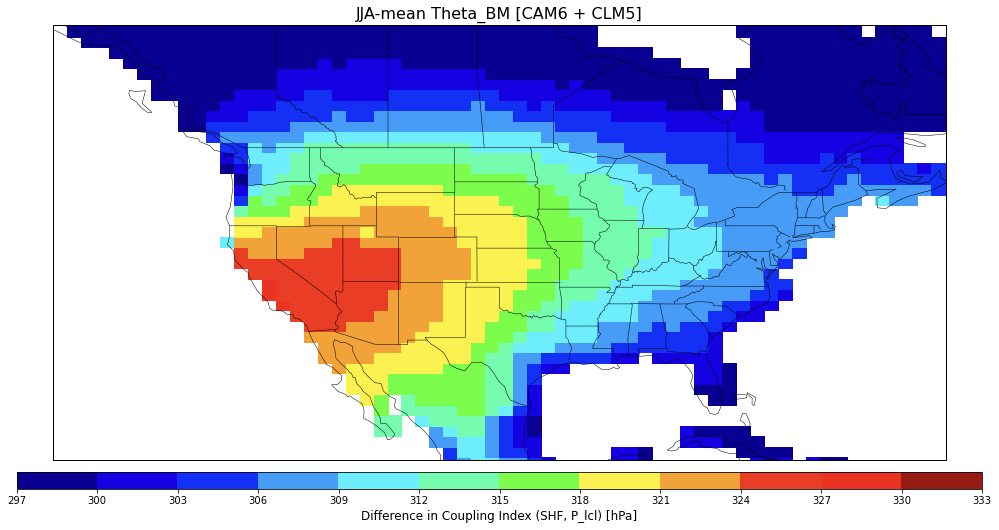

In [20]:
# Plot mean Theta_BM 
fig, ax1 = plt.subplots(1,1, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

# Zoom in on US
ax1.set_extent([-140,-60,21,60], crs=ccrs.PlateCarree())  


# ----- Plot difference from CESM1 ------ 
# Contour plots 
contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(thetaBM_CLM5, axis=0),
                             vmin=297,vmax=333,
                             cmap=my_cmap_Theta, norm=norm)

# Additional options 
ax1.set_title('JJA-mean Theta_BM [CAM6 + CLM5]',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='k')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='k')
#   Set up to add states to plots
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces,edgecolor='k',linewidth=0.5)

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,
                   cmap=my_cmap_Theta, norm=norm, ticks=bounds, boundaries=bounds)
cbar.set_label('Difference in Coupling Index (SHF, P_lcl) [hPa]',fontsize=12)


# # create a second axes for the colorbar
# cb = ax1.colorbar(cmap=cmap, norm=norm, ticks=bounds, boundaries=bounds, format='%1i')




<ipython-input-21-9fea2e9d9357>:12: RuntimeWarning: Mean of empty slice
  contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(thetaBM_CLM45, axis=0),


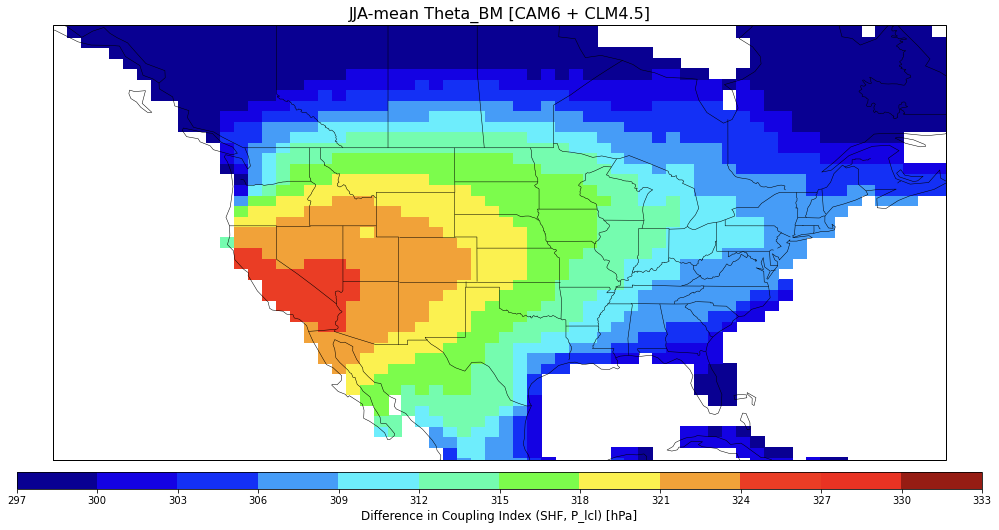

In [21]:
# Plot mean TBM 
fig, ax1 = plt.subplots(1,1, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

# Zoom in on US
ax1.set_extent([-140,-60,21,60], crs=ccrs.PlateCarree())  


# ----- Plot difference from CESM1 ------ 
# Contour plots 
contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(thetaBM_CLM45, axis=0),
                             vmin=297,vmax=333,
                             cmap=my_cmap_Theta, norm=norm)

# Additional options 
ax1.set_title('JJA-mean Theta_BM [CAM6 + CLM4.5]',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='k')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='k')
#   Set up to add states to plots
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces,edgecolor='k',linewidth=0.5)

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,
                   cmap=my_cmap_Theta, norm=norm, ticks=bounds, boundaries=bounds)
cbar.set_label('Difference in Coupling Index (SHF, P_lcl) [hPa]',fontsize=12)


# # create a second axes for the colorbar
# cb = ax1.colorbar(cmap=cmap, norm=norm, ticks=bounds, boundaries=bounds, format='%1i')





<ipython-input-22-994f13e57232>:15: RuntimeWarning: Mean of empty slice
  contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(diff_thetaBM, axis=0)*landMask,


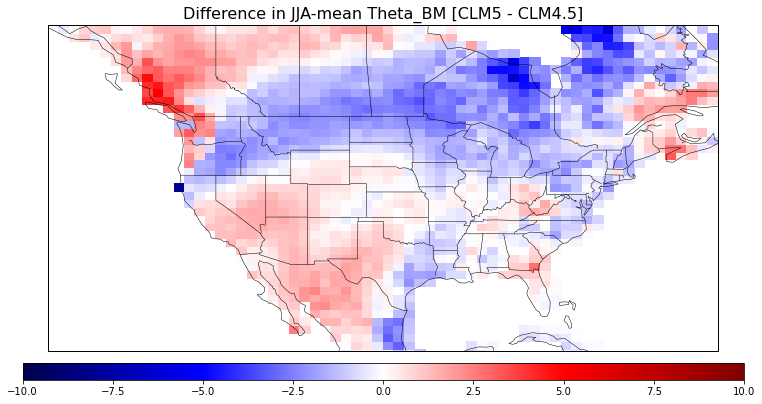

In [22]:
# Plot difference in modeled Theta_BM (CLM5 - CLM4.5)

diff_thetaBM = thetaBM_CLM5 - thetaBM_CLM45

fig, ax1 = plt.subplots(1,1, figsize=(12, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

# Zoom in on US
ax1.set_extent([-140,-60,21,60], crs=ccrs.PlateCarree())  


# ----- Plot difference from CESM1 ------ 
# Contour plots 
contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(diff_thetaBM, axis=0)*landMask,
                             vmin=-10,vmax=10,
                             cmap='seismic')

# Additional options 
ax1.set_title('Difference in JJA-mean Theta_BM [CLM5 - CLM4.5]',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='k')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='k')
#   Set up to add states to plots
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces,edgecolor='k',linewidth=0.5)

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)



### 3.2 Summer mean theta-advantage (transition from moisture input to BL growth advantage) 


<ipython-input-20-6916531b768c>:12: RuntimeWarning: Mean of empty slice
  contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(thetaAdv_CLM5, axis=0),


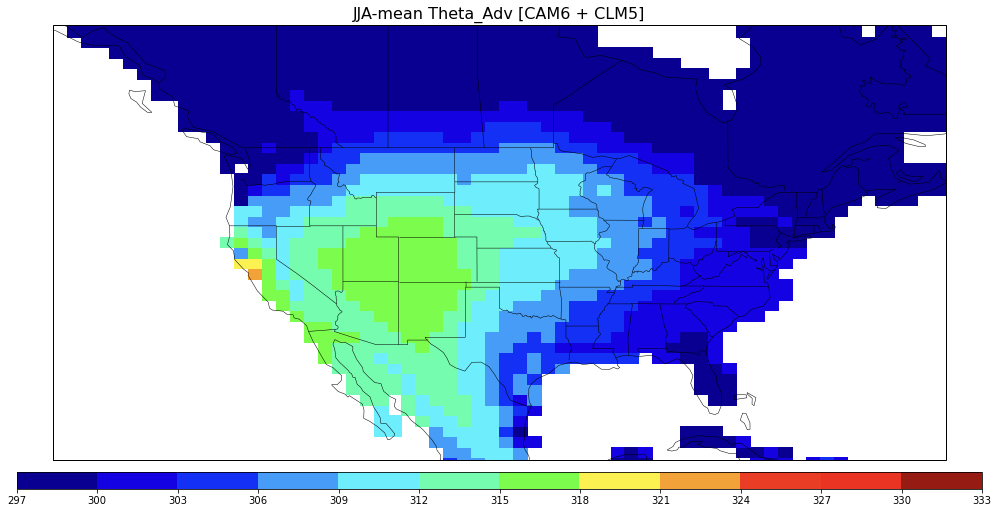

In [20]:
# Plot mean Theta_Adv 
fig, ax1 = plt.subplots(1,1, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

# Zoom in on US
ax1.set_extent([-140,-60,21,60], crs=ccrs.PlateCarree())  


# ----- Plot difference from CESM1 ------ 
# Contour plots 
contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(thetaAdv_CLM5, axis=0),
                             vmin=297,vmax=333,
                             cmap=my_cmap_Theta, norm=norm)

# Additional options 
ax1.set_title('JJA-mean Theta_Adv [CAM6 + CLM5]',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='k')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='k')
#   Set up to add states to plots
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces,edgecolor='k',linewidth=0.5)

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,
                   cmap=my_cmap_Theta, norm=norm, ticks=bounds, boundaries=bounds)


# # create a second axes for the colorbar
# cb = ax1.colorbar(cmap=cmap, norm=norm, ticks=bounds, boundaries=bounds, format='%1i')



<ipython-input-21-69c01d73cb80>:12: RuntimeWarning: Mean of empty slice
  contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(thetaAdv_CLM45, axis=0),


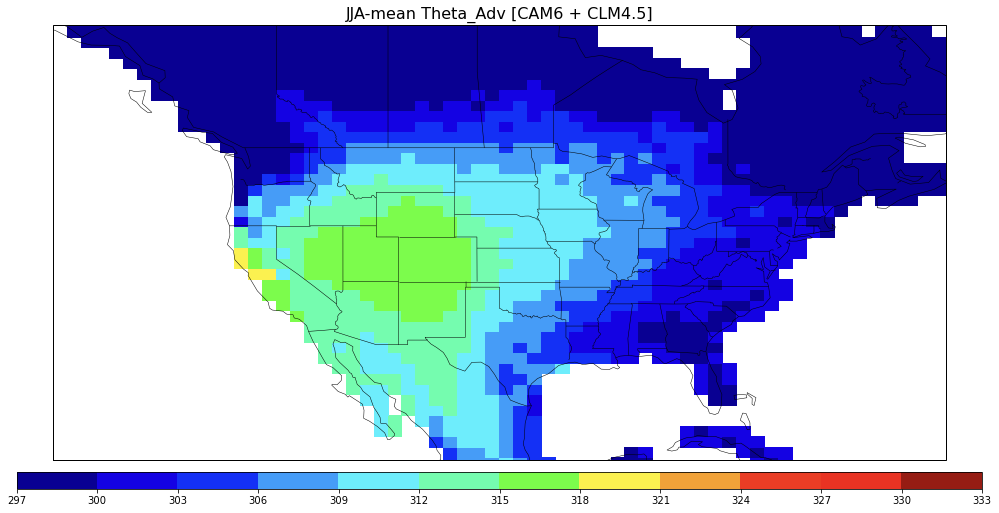

In [21]:
# Plot mean Theta_Adv 
fig, ax1 = plt.subplots(1,1, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

# Zoom in on US
ax1.set_extent([-140,-60,21,60], crs=ccrs.PlateCarree())  


# ----- Plot difference from CESM1 ------ 
# Contour plots 
contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(thetaAdv_CLM45, axis=0),
                             vmin=297,vmax=333,
                             cmap=my_cmap_Theta, norm=norm)

# Additional options 
ax1.set_title('JJA-mean Theta_Adv [CAM6 + CLM4.5]',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='k')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='k')
#   Set up to add states to plots
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces,edgecolor='k',linewidth=0.5)

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,
                   cmap=my_cmap_Theta, norm=norm, ticks=bounds, boundaries=bounds)


# # create a second axes for the colorbar
# cb = ax1.colorbar(cmap=cmap, norm=norm, ticks=bounds, boundaries=bounds, format='%1i')






## 4. Read in longer  in longer timeseries of theta - get distribution of daily maximum theta_2m 

In [23]:
# -----------------------------
# 20 years of theta, CLM5+CAM6 
# -----------------------------
CLM5dir    = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/3hrSim_CAM6-CLM5/'
clm5_file1 = CLM5dir+'f.e21.FHIST.f09_f09.cesm2_cam6_clm5.001.cam.h4.1979-1989_sfcPotentialTemperature.nc'
clm5_file2 = CLM5dir+'f.e21.FHIST.f09_f09.cesm2_cam6_clm5.001.cam.h4.1990-1999_sfcPotentialTemperature.nc'

with xr.open_dataset(clm5_file1,decode_times=True) as clm5_ds1: 
    clm5_ds1['time'] =  clm5_ds1.indexes['time'].to_datetimeindex()
    
with xr.open_dataset(clm5_file2,decode_times=True) as clm5_ds2: 
    clm5_ds2['time'] =  clm5_ds2.indexes['time'].to_datetimeindex()
    
clm5_thetaDS = xr.concat([clm5_ds1, clm5_ds2], dim='time')
print('CAM6+CLM5 theta files saved to: clm5_thetaDS')

# -----------------------------
# 20 years of theta, CLM45+CAM6
# -----------------------------
CLM45dir    = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/3hrSim_CAM6-CLM45/'

clm45_file1 = CLM45dir+'f.e21.FHIST.f09_f09.cesm2_cam6_clm4p5.001.cam.h4.1979-1989_sfcPotentialTemperature.nc'
clm45_file2 = CLM45dir+'f.e21.FHIST.f09_f09.cesm2_cam6_clm4p5.001.cam.h4.1990-1999_sfcPotentialTemperature.nc'

with xr.open_dataset(clm45_file1,decode_times=True) as clm45_ds1: 
    clm45_ds1['time'] =  clm45_ds1.indexes['time'].to_datetimeindex()
    
with xr.open_dataset(clm45_file2,decode_times=True) as clm45_ds2: 
    clm45_ds2['time'] =  clm45_ds2.indexes['time'].to_datetimeindex()
    
clm45_thetaDS = xr.concat([clm45_ds1, clm45_ds2], dim='time')
print('CAM6+CLM5 theta files saved to: clm45_thetaDS')


<ipython-input-23-99ab74c0a646>:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clm5_ds1['time'] =  clm5_ds1.indexes['time'].to_datetimeindex()
<ipython-input-23-99ab74c0a646>:12: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clm5_ds2['time'] =  clm5_ds2.indexes['time'].to_datetimeindex()


CAM6+CLM5 theta files saved to: clm5_thetaDS


<ipython-input-23-99ab74c0a646>:26: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clm45_ds1['time'] =  clm45_ds1.indexes['time'].to_datetimeindex()
<ipython-input-23-99ab74c0a646>:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clm45_ds2['time'] =  clm45_ds2.indexes['time'].to_datetimeindex()


CAM6+CLM5 theta files saved to: clm45_thetaDS


In [24]:
# Limit years to be 1980-1999 (ignore 1979 as spin up)
dates_CLM5  = pd.DatetimeIndex(clm5_thetaDS['time'].values)      # 1: Pull out dates to usable form 
dates_CLM45 = pd.DatetimeIndex(clm45_thetaDS['time'].values)

iTimes_CLM5  = np.where( dates_CLM5.year>=1980 )[0]              # 2: Find indices of times 1980-1999
iTimes_CLM45 = np.where( dates_CLM45.year>=1980)[0]

clm5_thetaDS_timeSel  = clm5_thetaDS.isel(time=iTimes_CLM5)      # 3: Select indices in full datasets 
clm45_thetaDS_timeSel = clm45_thetaDS.isel(time=iTimes_CLM45) 


In [25]:
# Get daily maximum values of theta (have confirmed this works as expected)
dailyMax_CLM5  = clm5_thetaDS_timeSel.resample(time="1D").max()
dailyMax_CLM45 = clm45_thetaDS_timeSel.resample(time="1D").max()


In [26]:
# Get time from the *daily* maximum dataset, otherwise working with 3-hourly stuff still 
dates_CLM5  = pd.DatetimeIndex(dailyMax_CLM5['time'].values)
dates_CLM45 = pd.DatetimeIndex(dailyMax_CLM45['time'].values)


In [27]:
# Select JJA only 
iJJA_CLM5  = np.where( (dates_CLM5.month>=6)  & (dates_CLM5.month<=8) )[0]
iJJA_CLM45 = np.where( (dates_CLM45.month>=6) & (dates_CLM45.month<=8) )[0]

dailyMax_CLM5_JJA  = dailyMax_CLM5.isel(time=iJJA_CLM5)
dailyMax_CLM45_JJA = dailyMax_CLM45.isel(time=iJJA_CLM45)


In [25]:
dailyMax_CLM5_JJA

<xarray.Dataset>
Dimensions:        (lat: 43, lon: 65, time: 1840)
Coordinates:
  * time           (time) datetime64[ns] 1980-06-01 1980-06-02 ... 1999-08-31
  * lat            (lat) float64 20.26 21.2 22.15 23.09 ... 57.96 58.9 59.84
  * lon            (lon) float64 220.0 221.2 222.5 223.8 ... 297.5 298.8 300.0
Data variables:
    THETA_PS_TBOT  (time, lat, lon) float32 292.8132 292.6242 ... 277.92746
    THETA_PS_TREF  (time, lat, lon) float32 293.57724 293.38672 ... 278.23157
    UTC_hr         (time) float64 21.0 21.0 21.0 21.0 ... 21.0 21.0 21.0 21.0
    UTC_day        (time) float64 1.0 2.0 3.0 4.0 5.0 ... 28.0 29.0 30.0 31.0
    UTC_mon        (time) float64 6.0 6.0 6.0 6.0 6.0 ... 8.0 8.0 8.0 8.0 8.0
    UTC_yr         (time) float64 1.98e+03 1.98e+03 ... 1.999e+03 1.999e+03

### 4.1 Maps of JJA-mean thetaMax, following Fig. 3 of Tawfik et al. (2015):

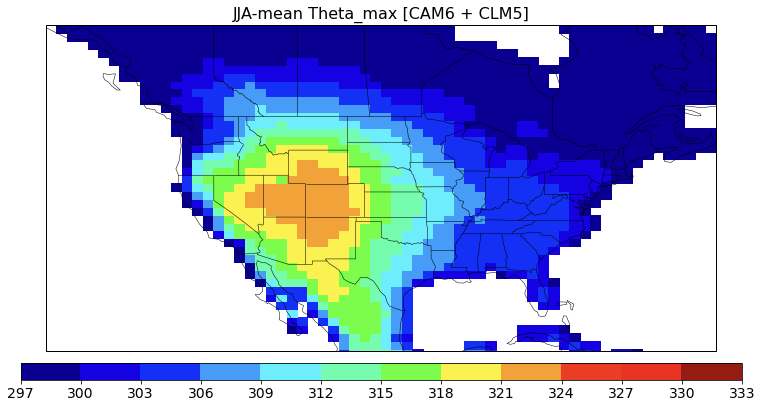

In [75]:
# Plot mean Theta_Max
fig, ax1 = plt.subplots(1,1, figsize=(12, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

# Zoom in on US
ax1.set_extent([-140,-60,21,60], crs=ccrs.PlateCarree())  


# ----- Plot difference from CESM1 ------ 
# Contour plots 
contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(dailyMax_CLM5_JJA.THETA_PS_TREF.values, axis=0)*landMask,
                             vmin=297,vmax=333,
                             cmap=my_cmap_Theta, norm=norm)

# Additional options 
ax1.set_title('JJA-mean Theta_max [CAM6 + CLM5]',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='k')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='k')
#   Set up to add states to plots
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces,edgecolor='k',linewidth=0.5)

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,
                   cmap=my_cmap_Theta, norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=14)


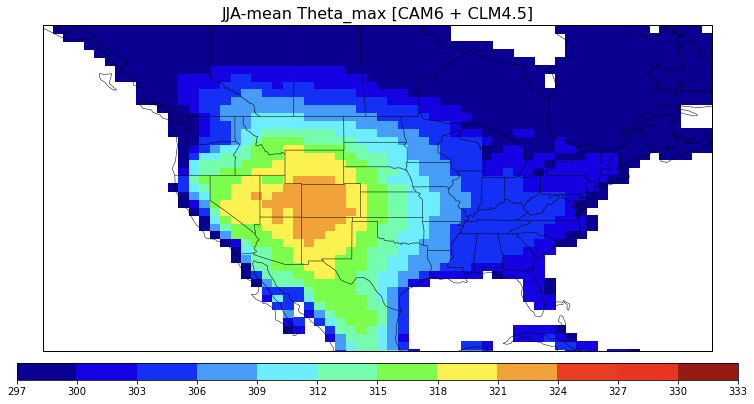

In [76]:
# Plot mean Theta_Max 
fig, ax1 = plt.subplots(1,1, figsize=(12, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

# Zoom in on US
ax1.set_extent([-140,-60,21,60], crs=ccrs.PlateCarree())  


# ----- Plot difference from CESM1 ------ 
# Contour plots 
contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(dailyMax_CLM45_JJA.THETA_PS_TREF.values, axis=0)*landMask,
                             vmin=297,vmax=333,
                             cmap=my_cmap_Theta, norm=norm)

# Additional options 
ax1.set_title('JJA-mean Theta_max [CAM6 + CLM4.5]',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='k')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='k')
#   Set up to add states to plots
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces,edgecolor='k',linewidth=0.5)

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,
                   cmap=my_cmap_Theta, norm=norm, ticks=bounds, boundaries=bounds)




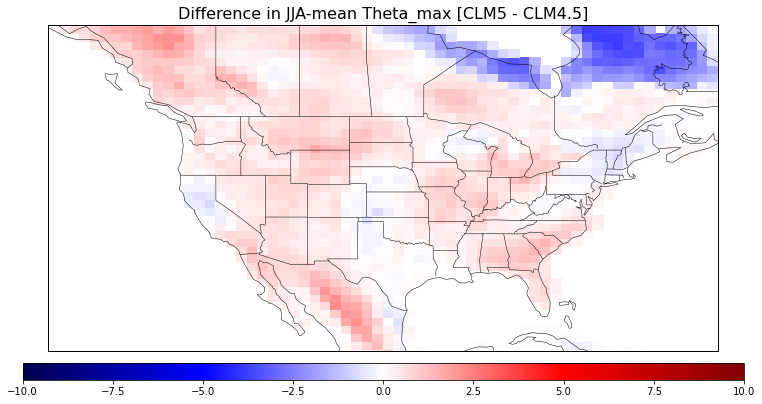

In [77]:
# Plot difference in modeled Theta_Max (CLM5 - CLM4.5)

diff_thetaMax = dailyMax_CLM5_JJA.THETA_PS_TREF.values - dailyMax_CLM45_JJA.THETA_PS_TREF.values

fig, ax1 = plt.subplots(1,1, figsize=(12, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

# Zoom in on US
ax1.set_extent([-140,-60,21,60], crs=ccrs.PlateCarree())  


# ----- Plot difference from CESM1 ------ 
# Contour plots 
contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(diff_thetaMax, axis=0)*landMask,
                             vmin=-10,vmax=10,
                             cmap='seismic')

# Additional options 
ax1.set_title('Difference in JJA-mean Theta_max [CLM5 - CLM4.5]',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='k')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='k')
#   Set up to add states to plots
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces,edgecolor='k',linewidth=0.5)

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)





### 4.2 Take a look at histograms of thetaMax for all JJA points over land

In [31]:
# Set array of bin edges to worry about 
binEdges   = np.arange(240,360,0.5)
binCenters = binEdges[:-1]+((binEdges[1]-binEdges[0])/2)
binWidth   = binEdges[1]-binEdges[0]


In [53]:
# Get PDF over all land gridcells...: 
[hist_clm5,  edges_clm5]  = np.histogram((dailyMax_CLM5_JJA.THETA_PS_TREF.values*landMask).reshape(len(lat)*len(lon)*len(dailyMax_CLM5_JJA.time.values)),   bins=binEdges, density=True)
[hist_clm45, edges_clm45] = np.histogram((dailyMax_CLM45_JJA.THETA_PS_TREF.values*landMask).reshape(len(lat)*len(lon)*len(dailyMax_CLM45_JJA.time.values)), bins=binEdges, density=True)


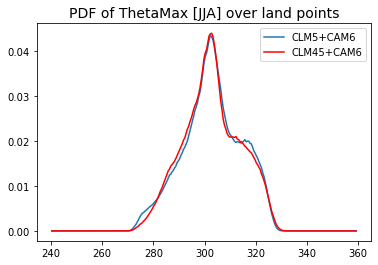

In [54]:
plt.plot(binCenters,hist_clm5,'-')
plt.plot(binCenters, hist_clm45,'r-')
plt.legend(['CLM5+CAM6', 'CLM45+CAM6'])
plt.title('PDF of ThetaMax [JJA] over land points',fontsize=14)

plt.show()


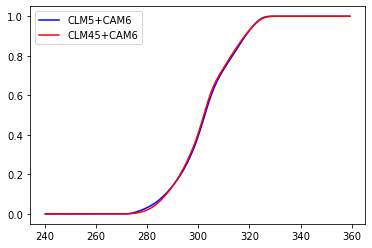

In [55]:
# Also plot cumulative distribution function - 
#  Assuming this is how you get actual probability of convective initiation 

cdf_clm5  = np.cumsum(hist_clm5)*binWidth
cdf_clm45 = np.cumsum(hist_clm45)*binWidth 

plt.plot(binCenters,cdf_clm5,'b-')
plt.plot(binCenters, cdf_clm45,'r-')
plt.legend(['CLM5+CAM6', 'CLM45+CAM6'])


### 4.3 Using PDF of thetaMax per point - what is likelihood of local CI?

In [32]:
# But probably want to do this by point... 
pdf_CLM5  = np.full([len(lat),len(lon),len(binEdges)-1], np.nan)
pdf_CLM45 = np.full([len(lat),len(lon),len(binEdges)-1], np.nan)
cdf_CLM5  = np.full([len(lat),len(lon),len(binEdges)-1], np.nan)
cdf_CLM45 = np.full([len(lat),len(lon),len(binEdges)-1], np.nan)

for ilat in range(len(lat)):
    for ilon in range(len(lon)): 
        dataCLM5  = np.squeeze(dailyMax_CLM5_JJA.THETA_PS_TREF.values[:,ilat,ilon]*landMask[ilat,ilon])
        dataCLM45 = np.squeeze(dailyMax_CLM45_JJA.THETA_PS_TREF.values[:,ilat,ilon]*landMask[ilat,ilon])
        
        # Compute bin counts 
        [histPoint_clm5, edges_clm5]   = np.histogram(dataCLM5,bins=binEdges, density=True)
        [histPoint_clm45, edges_clm45] = np.histogram(dataCLM45,bins=binEdges, density=True)
        
        cdf_CLM5[ilat,ilon,:]  = np.cumsum(histPoint_clm5)*binWidth
        cdf_CLM45[ilat,ilon,:] = np.cumsum(histPoint_clm45)*binWidth 
        
        # Save out to array
        pdf_CLM5[ilat,ilon,:]  = histPoint_clm5
        pdf_CLM45[ilat,ilon,:] = histPoint_clm45
        

Now that we have a PDF for all JJA daily maximum potential temperatures for each land gridcell, we need to get the probability of local convective initiation, based on theta_BM. The question I have is *how* exactly that was calculated in Tawfik et al. (2015). There's only one map, and it doesn't say it's a mean of anything; so I don't think the intent is to get a specific percentage change of theta each day and average up. It makes most sense to use a somewhat binary system for each day - is the buoyant mixing potential temperature outside the range of daily maximum 2m theta: yes = 0, no = 1. Then what percentage of all days are 1's as opposed to zeros? That is, what percentage of days have the *possbility* of local convective initiation? 

thetaBM:  310.5683295229828
Bin Center:  [310.75]
probBin:  [0.02631579]
probability:  [0.22336957]


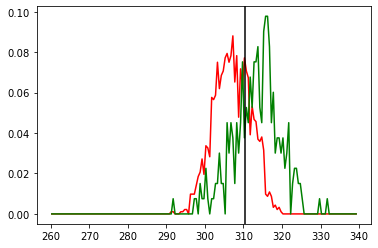

In [37]:
ilat = 20 
ilon = 40 

plt.plot(binCenters, pdf_CLM5[ilat,ilon,:],'r-')

# Histogram of thetaBM 
[histPoint_clm5, edges_clm5]   = np.histogram(thetaBM_CLM5[:,ilat,ilon],bins=binEdges, density=True)
plt.plot(binCenters,histPoint_clm5,'g-')


iTime    = 100
modelVal = thetaBM_CLM5[iTime,ilat,ilon]
iBin     = np.where((binCenters>=modelVal-(binWidth/2)) & (binCenters<=modelVal+(binWidth/2)))[0]
print('thetaBM: ', modelVal)
print('Bin Center: ', binCenters[iBin])
print('probBin: ', histPoint_clm5[iBin]*binWidth)
print('probability: ', (1-cdf_CLM5[ilat,ilon,iBin]))

plt.axvline(edges_clm5[iBin],color='k')


thetaBM:  310.5683295229828
Bin Center:  [310.75]
probability:  [0.22336957]


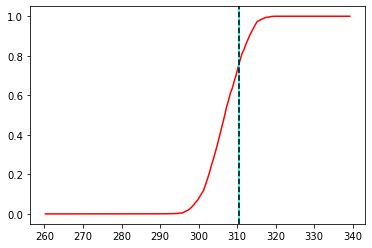

In [39]:
ilat = 20 
ilon = 40 

plt.plot(binCenters, cdf_CLM5[ilat,ilon,:],'r-')


iTime    = 100
modelVal = thetaBM_CLM5[iTime,ilat,ilon]
plt.axvline(modelVal,color='cyan')

iBin     = np.where((binCenters>=modelVal-(binWidth/2)) & (binCenters<=modelVal+(binWidth/2)))[0]

print('thetaBM: ', modelVal)
print('Bin Center: ', binCenters[iBin])
print('probability: ', (1-cdf_CLM5[ilat,ilon,iBin]))

plt.axvline(edges_clm5[iBin],color='k',linestyle='--')



In [33]:
# Probability of exceeding ThetaBM per day 
CIprob_CLM5  = np.full([np.shape(thetaBM_CLM5)[0], len(lat),len(lon)], np.nan) 
CIprob_CLM45 = np.full([np.shape(thetaBM_CLM45)[0], len(lat),len(lon)], np.nan)  

for ilat in range(len(lat)):
    for ilon in range(len(lon)):
        # ------------------------------
        #  Get PDF of thetaMax at point
        # ------------------------------
        dataCLM5  = np.squeeze(dailyMax_CLM5_JJA.THETA_PS_TREF.values[:,ilat,ilon]*landMask[ilat,ilon])
        dataCLM45 = np.squeeze(dailyMax_CLM45_JJA.THETA_PS_TREF.values[:,ilat,ilon]*landMask[ilat,ilon])
        
        # Compute bin counts 
        [histPoint_clm5, edges_clm5]   = np.histogram(dataCLM5,bins=binEdges, density=True)
        [histPoint_clm45, edges_clm45] = np.histogram(dataCLM45,bins=binEdges, density=True)
        
        # Compute CDF
        cdf_clm5  = np.cumsum(histPoint_clm5)*binWidth
        cdf_clm45 = np.cumsum(histPoint_clm45)*binWidth 

        # ---------------------------------
        #  Compare thetaBM each day to PDF
        # ---------------------------------
        for iTime in range(np.shape(thetaBM_CLM45)[0]): 
            thetaBM_CLM5_day  = thetaBM_CLM5[iTime,ilat,ilon]
            thetaBM_CLM45_day = thetaBM_CLM45[iTime,ilat,ilon]
            
            if (np.isfinite(thetaBM_CLM5_day)==True): 
                # Bin containing the day's thetaBM 
                iBin     = np.where((binCenters>=thetaBM_CLM5_day-(binWidth/2)) & (binCenters<=thetaBM_CLM5_day+(binWidth/2)))[0]
                # Probability of exceeding thetaBM 
                CIprob_CLM5[iTime,ilat,ilon] = 1.0 - cdf_clm5[iBin]
                    
            if (np.isfinite(thetaBM_CLM45_day)==True): 
                # Bin containing the day's thetaBM 
                iBin     = np.where((binCenters>=thetaBM_CLM45_day-(binWidth/2)) & (binCenters<=thetaBM_CLM45_day+(binWidth/2)))[0]
                # Probability of exceeding thetaBM 
                CIprob_CLM45[iTime,ilat,ilon] = 1.0 - cdf_clm45[iBin]


In [34]:
### Create a list of RGB tuples
colorsList_prob = [( 179,179,179), 
                     ( 90, 86,182),
                     ( 10,  0,183),
                     ( 10,100,182),
                     (  0,178,  0),
                     (142,140,  0),
                     (204, 67,  0),
                     (207, 14,  0),
                     (254,  2,  0)] # This example uses the 8-bit RGB

my_cmap_probCI = make_cmap(colorsList_prob, bit=True)

bounds = np.asarray([0,5,15,25,35,45,55,65,75,85])
norm   = colors.BoundaryNorm(boundaries=bounds, ncolors=256)


<ipython-input-35-cf56c9efbadb>:13: RuntimeWarning: Mean of empty slice
  contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(CIprob_CLM5,axis=0)*100,


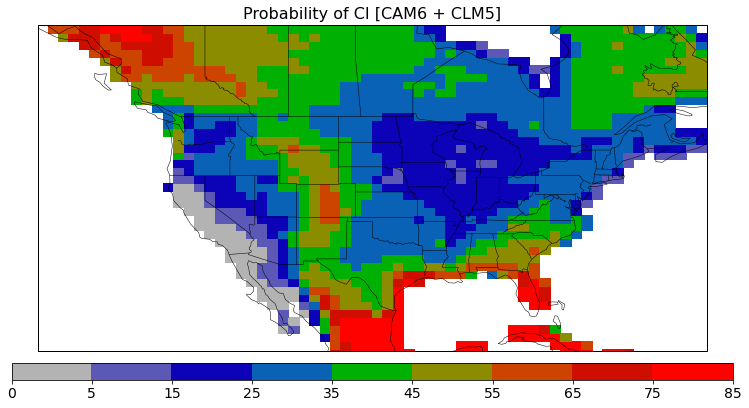

In [35]:
# Plot likelihood of local CI in CLM5

fig, ax1 = plt.subplots(1,1, figsize=(12, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

# Zoom in on US
ax1.set_extent([-140,-60,21,60], crs=ccrs.PlateCarree())  


# ----- Plot difference from CESM1 ------ 
# Contour plots 
contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(CIprob_CLM5,axis=0)*100,
                             vmin=0,vmax=85,
                             cmap=my_cmap_probCI, norm=norm)

# Additional options 
ax1.set_title('Probability of CI [CAM6 + CLM5]',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='k')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='k')
#   Set up to add states to plots
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces,edgecolor='k',linewidth=0.5)

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,
                   cmap=my_cmap_probCI, norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=14)



<ipython-input-36-1309a33e7b76>:12: RuntimeWarning: Mean of empty slice
  contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(CIprob_CLM45,axis=0)*100,


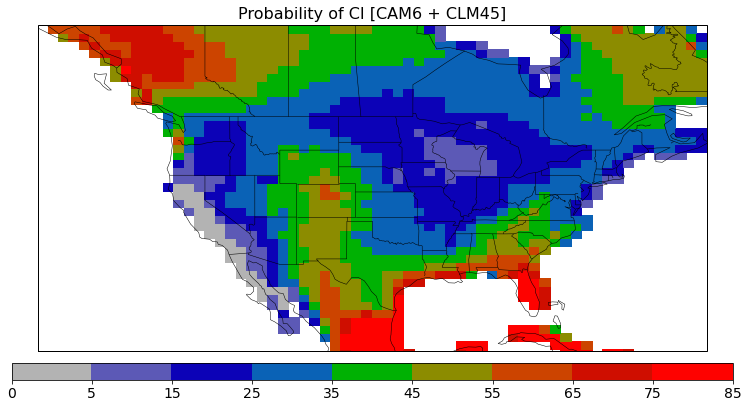

In [36]:
# Plot likelihood of local CI in CLM4.5
fig, ax1 = plt.subplots(1,1, figsize=(12, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

# Zoom in on US
ax1.set_extent([-140,-60,21,60], crs=ccrs.PlateCarree())  


# ----- Plot difference from CESM1 ------ 
# Contour plots 
contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(CIprob_CLM45,axis=0)*100,
                             vmin=0,vmax=85,
                             cmap=my_cmap_probCI, norm=norm)

# Additional options 
ax1.set_title('Probability of CI [CAM6 + CLM45]',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='k')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='k')
#   Set up to add states to plots
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces,edgecolor='k',linewidth=0.5)

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar        = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax,
                   cmap=my_cmap_probCI, norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=14)


### Some interesting differences...

<ipython-input-96-8ca7d86e9105>:15: RuntimeWarning: Mean of empty slice
  contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(probCI_diff,axis=0)*100,


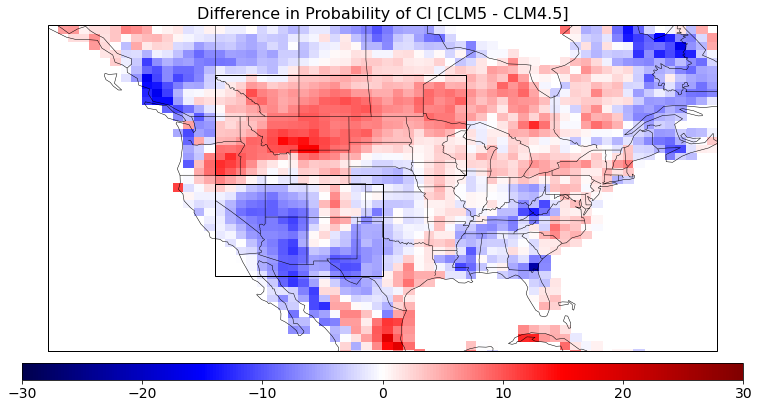

In [96]:
# Plot difference in percent likelihood of local CI (CLM5 - CLM4.5)
probCI_diff = CIprob_CLM5-CIprob_CLM45


fig, ax1 = plt.subplots(1,1, figsize=(12, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

# Zoom in on US
ax1.set_extent([-140,-60,21,60], crs=ccrs.PlateCarree())  


# ----- Plot difference from CESM1 ------ 
# Contour plots 
contour_plot = ax1.pcolormesh(lon,lat, np.nanmean(probCI_diff,axis=0)*100,
                             vmin=-30,vmax=30,
                             cmap='seismic')

# Additional options 
ax1.set_title('Difference in Probability of CI [CLM5 - CLM4.5]',fontsize=16)
ax1.coastlines(linewidth=0.5,edgecolor='k')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='k')
#   Set up to add states to plots
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces,edgecolor='k',linewidth=0.5)

# Add colorbar 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.03, ax_position.y0-0.05, ax_position.width+0.06, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.ax.tick_params(labelsize=14)

# Draw rectangles defining region of interest 
ax1.add_patch(mpatches.Rectangle(xy=[-120, 30], width=20, height=11,
                                    facecolor='none',
                                    edgecolor='k',
                                    transform=ccrs.PlateCarree())
                 )

ax1.add_patch(mpatches.Rectangle(xy=[-120, 42], width=30, height=12,
                                    facecolor='none',
                                    edgecolor='k',
                                    transform=ccrs.PlateCarree())
                 )


In [ ]:
# Get lat and lon boundaries of boxes above



## Timing tests

In [101]:
ds_utc12_CLM5

<xarray.Dataset>
Dimensions:   (lat: 43, lev: 32, lon: 65, time: 1095)
Coordinates:
  * lat       (lat) float64 20.26 21.2 22.15 23.09 ... 57.02 57.96 58.9 59.84
  * lon       (lon) float64 220.0 221.2 222.5 223.8 ... 296.2 297.5 298.8 300.0
  * lev       (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time      (time) datetime64[ns] 1980-01-01T12:00:00 ... 1982-12-31T12:00:00
Data variables:
    hyam      (time, lev) float64 0.003643 0.007595 0.01436 ... 0.001989 0.0
    hybm      (time, lev) float64 0.0 0.0 0.0 0.0 ... 0.9512 0.9743 0.9926
    P0        (time) float64 1e+05 1e+05 1e+05 1e+05 ... 1e+05 1e+05 1e+05 1e+05
    PS        (time, lat, lon) float32 101915.88 101913.83 ... 96351.516
    Q         (time, lev, lat, lon) float32 2.763311e-06 ... 0.0011067796
    T         (time, lev, lat, lon) float32 246.99518 247.01498 ... 262.0397
    Z3        (time, lev, lat, lon) float32 37905.402 37906.48 ... 57.810844
    PRESSURE  (time, lev, lat, lon) float32 364.34656 364.34656 ... 95634.28
    UTC_hr    (time) float32 12.0 12.0 12.0 12.0 12.0 ... 12.0 12.0 12.0 12.0
    UTC_day   (time) float32 1.0 2.0 3.0 4.0 5.0 ... 27.0 28.0 29.0 30.0 31.0
    UTC_mon   (time) float32 1.0 1.0 1.0 1.0 1.0 ... 12.0 12.0 12.0 12.0 12.0
    UTC_yr    (time) float32 1980.0 1980.0 1980.0 ... 1982.0 1982.0 1982.0
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              f.e21.FHIST.f09_f09.cesm2_cam6_clm5.001
    logname:           islas
    host:              cheyenne2
    initial_file:      f.e20.FHIST.f09_f09.cesm2_1.001.cam.i.1979-01-01-00000.nc
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_0.9x1...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  hour_3
    history:           Tue Nov 10 11:23:12 2020: ncrcat -d lat,20.0,60.0 -d l...
    NCO:               netCDF Operators version 4.7.9 (Homepage = http://nco....

## Completely re-work HCF script

In [72]:
levVert = np.arange(1,nlev)
np.shape(DS[Tname].isel(lev=levVert).values)

(20, 31, 20, 20)

In [79]:
DS

<xarray.Dataset>
Dimensions:   (lat: 20, lev: 32, lon: 20, time: 20)
Coordinates:
  * lat       (lat) float64 20.26 21.2 22.15 23.09 ... 35.34 36.28 37.23 38.17
  * lon       (lon) float64 220.0 221.2 222.5 223.8 ... 240.0 241.2 242.5 243.8
  * lev       (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time      (time) datetime64[ns] 1980-01-01T12:00:00 ... 1980-01-20T12:00:00
Data variables:
    hyam      (time, lev) float64 0.003643 0.007595 0.01436 ... 0.001989 0.0
    hybm      (time, lev) float64 0.0 0.0 0.0 0.0 ... 0.9512 0.9743 0.9926
    P0        (time) float64 1e+05 1e+05 1e+05 1e+05 ... 1e+05 1e+05 1e+05 1e+05
    PS        (time, lat, lon) float32 101915.88 101913.83 ... 81101.5 81515.03
    Q         (time, lev, lat, lon) float32 2.763311e-06 ... 0.000778381
    T         (time, lev, lat, lon) float32 246.99518 247.01498 ... 254.72763
    Z3        (time, lev, lat, lon) float32 37905.402 37906.48 ... 1868.1151
    PRESSURE  (time, lev, lat, lon) float32 364.34656 364.34656 ... 80908.24
    UTC_hr    (time) float32 12.0 12.0 12.0 12.0 12.0 ... 12.0 12.0 12.0 12.0
    UTC_day   (time) float32 1.0 2.0 3.0 4.0 5.0 ... 16.0 17.0 18.0 19.0 20.0
    UTC_mon   (time) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
    UTC_yr    (time) float32 1980.0 1980.0 1980.0 ... 1980.0 1980.0 1980.0
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              f.e21.FHIST.f09_f09.cesm2_cam6_clm5.001
    logname:           islas
    host:              cheyenne2
    initial_file:      f.e20.FHIST.f09_f09.cesm2_1.001.cam.i.1979-01-01-00000.nc
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_0.9x1...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  hour_3
    history:           Tue Nov 10 11:23:12 2020: ncrcat -d lat,20.0,60.0 -d l...
    NCO:               netCDF Operators version 4.7.9 (Homepage = http://nco....

In [123]:
# Need to reorde so lev at sfc is index 0
DS = DS.sortby('lev', ascending=False)

In [126]:
latName  = 'lat'
lonName  = 'lon'
timeName = 'time'
levName  = 'lev'


In [350]:
import numpy.ma as ma
import warnings

#Suppress warnings that arise from NaN's and masked arrays
warnings.filterwarnings("once")

nLat = len(DS[latName].values)
nLon = len(DS[lonName].values)
nT   = len(DS[timeName].values)

# Profile starting at level above sfc
levVert = np.arange(1,nlev)

tmp_in   = DS[Tname].isel(lev=levVert).values
qhum_in  = DS[Qname].isel(lev=levVert).values
hgt_in   = DS[Zname].isel(lev=levVert).values
press_in = DS[Pname].isel(lev=levVert).values
    
# Sfc values set as first level values 
t2m      = DS[Tname].isel(lev=0).values
q2m      = DS[Qname].isel(lev=0).values
h2m      = DS[Zname].isel(lev=0).values
psfc     = DS[Pname].isel(lev=0).values

# Number of levels to worry about in actual "sounding"
nlev1 = nlevs-1 

# -----------------------------------------------
#    Set constants 
# -----------------------------------------------
p_ref  = 1e5 
Lv     = 2.5e6 
cp     = 1005.7
R_cp   = 287.04/1005.7

grav   = 9.81 
Rd     = 287.04
pi     = np.pi
cp_g   = cp/grav
Lv_g   = Lv/grav
r2d    = 180./pi

by100  = 1e2
t0     = 273.15 
ep     = 0.622
es0    = 6.11
a      = 17.269
b      = 35.86
onemep = 1.0 - ep

# -----------------------------------------------
#    Initiate empty arrays 
# -----------------------------------------------
shdef = np.full([nT, nlev1+1, nLat, nLon], np.nan)
lhdef = np.full([nT, nlev1+1, nLat, nLon], np.nan)
eadv  = np.full([nT, nlev1+1, nLat, nLon], np.nan)
rhoh  = np.full([nT, nlev1+1, nLat, nLon], np.nan)
pbar  = np.full([nT, nlev1+1, nLat, nLon], np.nan)
qdef  = np.full([nT, nlev1+1, nLat, nLon], np.nan)
qmix  = np.full([nT, nlev1+1, nLat, nLon], np.nan)

qsat   = np.full([nT, nlev1+1, nLat, nLon], np.nan)
dpress = np.full([nT, nlev1+1, nLat, nLon], np.nan) 
qbar   = np.full([nT, nlev1+1, nLat, nLon], np.nan)
logp   = np.full([nT, nlev1+1, nLat, nLon], np.nan)
hbar   = np.full([nT, nlev1+1, nLat, nLon], np.nan)
tbar   = np.full([nT, nlev1+1, nLat, nLon], np.nan)
tmp_k  = np.full([nT, nlev1+1, nLat, nLon], np.nan)
press  = np.full([nT, nlev1+1, nLat, nLon], np.nan)
pot_k  = np.full([nT, nlev1+1, nLat, nLon], np.nan)
hgt    = np.full([nT, nlev1+1, nLat, nLon], np.nan)
qhum   = np.full([nT, nlev1+1, nLat, nLon], np.nan)

pot_diff = np.full([nT, nlev1+1, nLat, nLon], np.nan)
eadv_0   = np.full([nT, nlev1+1, nLat, nLon], np.nan)
xaxis    = np.full([nT, nlev1+1, nLat, nLon], np.nan)
xaxis1   = np.full([nT, nlev1+1, nLat, nLon], np.nan)
yaxis    = np.full([nT, nlev1+1, nLat, nLon], np.nan)
yaxis1   = np.full([nT, nlev1+1, nLat, nLon], np.nan)
integral = np.full([nT, nlev1+1, nLat, nLon], np.nan)
below    = np.full([nT, nlev1+1, nLat, nLon], np.nan)

# -----------------------------------------------
#  Initialize empty arrays for scalars
# -----------------------------------------------
pot2m     = np.full([nT, nLat, nLon], np.nan)
num_unsat = np.full([nT, nLat, nLon], np.nan)
i_unsat   = np.full([nT, nLat, nLon], np.nan)
num_sat   = np.full([nT, nLat, nLon], np.nan)
i_sat     = np.full([nT, nLat, nLon], np.nan)
sat_flag  = np.full([nT, nLat, nLon], np.nan)
p_up      = np.full([nT, nLat, nLon], np.nan)
t_up      = np.full([nT, nLat, nLon], np.nan)
h_up      = np.full([nT, nLat, nLon], np.nan)
q_up      = np.full([nT, nLat, nLon], np.nan)
m_up      = np.full([nT, nLat, nLon], np.nan)
p_lo      = np.full([nT, nLat, nLon], np.nan)
t_lo      = np.full([nT, nLat, nLon], np.nan)
h_lo      = np.full([nT, nLat, nLon], np.nan)
q_lo      = np.full([nT, nLat, nLon], np.nan)
m_lo      = np.full([nT, nLat, nLon], np.nan)

# Output arrays: 
TBM       = np.full([nT, nLat, nLon], np.nan)
BCLH      = np.full([nT, nLat, nLon], np.nan)
BCLP      = np.full([nT, nLat, nLon], np.nan)
TDEF      = np.full([nT, nLat, nLon], np.nan)
TRAN_H    = np.full([nT, nLat, nLon], np.nan)
TRAN_P    = np.full([nT, nLat, nLon], np.nan)
TRAN_T    = np.full([nT, nLat, nLon], np.nan)
SHDEF_M   = np.full([nT, nLat, nLon], np.nan)
LHDEF_M   = np.full([nT, nLat, nLon], np.nan)
EADV_M    = np.full([nT, nLat, nLon], np.nan)


# -----------------------------------------------
#    Store temp working arrays and initialize 
# -----------------------------------------------
nlev      = nlev1+1 

tmp_k[:,1:,:,:] = tmp_in 
hgt[:,1:,:,:]   = hgt_in
qhum[:,1:,:,:]  = qhum_in
press[:,1:,:,:] = press_in 

tmp_k[:,0,:,:] = t2m 
hgt[:,0,:,:]   = h2m
qhum[:,0,:,:]  = q2m 
press[:,0,:,:] = psfc

# -----------------------------------------------
# Run a few checks on pressure
#    (but most of this is unfortunately on the user)
# -----------------------------------------------

# Check that pressure levels aren't greater than the surface pressure 

if np.any(press[:,1:,:,:] >= np.repeat(psfc[:,np.newaxis,:,:],31,axis=1))==True:
    print('***** ERROR: lowest pressure level > surface pressure *****')

# Check ordering of Plev: 
if np.any(press[:,0,:,:]<press[:,-1,:,:])==True:
    print('***** ERROR: pressure levels should be reversed *****') 

# Check units of pressure 
if np.any(psfc<=2000.0)==True: 
    print('**** ERROR: pressures should be in Pa, not hPa *****') 
    

# -----------------------------------------------
#    Compute column potential temperature 
# -----------------------------------------------
pot_k = tmp_k * (p_ref/press)**(R_cp)

# -----------------------------------------------
#    Ignore missing data levels when calculating midpoints 
#     (shouldn't be an issue for model data)
# -----------------------------------------------
hbar = hgt
pbar = press
tbar = tmp_k

# -----------------------------------------------
#    Compute middle layer specific humidity average [kg/kg]
#    1st layer = the 2m sp. humidity above, then layer averages above 
# -----------------------------------------------
qbar = qhum 
qbar[:,1:nlev,:,:] = ( (qhum[:,1:nlev,:,:]*np.log(press[:,1:nlev,:,:]) + 
                  qhum[:,0:nlev-1,:,:]*np.log(press[:,0:nlev-1,:,:]) )  / 
                  np.log(press[:,1:nlev,:,:]*press[:,0:nlev-1,:,:]))
    
# -----------------------------------------------
#    Compute pressure difference of each layer 
# -----------------------------------------------
#  ! MDF: Changing this section around a bit. 
#         Ultimately, the check on dpress[0] should always 
#         go into the 'else', because it's currently all NaN. 
#         So let's just do that, rather than this check. 
dpress[:,0,:,:] = (psfc / (Rd * t2m * ((1. + (q2m/ep)) / (1. + q2m)) )) * grav * h2m 

# if dpress[0]<=0: 
#     dpress[0] = 1.0     # Set to 1 Pa because h2m is likely zero 
# else:
#     dpress[0]   = (psfc / (Rd * t2m * ((1. + (q2m/ep)) / (1. + q2m)) )) * grav * h2m 

# Model data shouldn't have any missing, so not using this line:
#    where( pbar(1:nlev-1).ne.missing  .and.  pbar(2:nlev).ne.missing )
dpress[:,1:nlev,:,:] = press[:,0:nlev-1,:,:] - press[:,1:nlev,:,:]

# -----------------------------------------------
#    Compute log pressure to linearize it for slope calculation 
# -----------------------------------------------
logp = np.log(pbar)
    
# -----------------------------------------------
#    Compute mixed layer sp. humidity and column density [kg/kg]
# -----------------------------------------------
qmix = qbar * dpress/grav
rhoh = dpress/grav

for izz in range(nlev-1):
    zz = izz+1    # .f90 is: do zz = 2, nlev; so going to increase index by one 
    
    # ! MDF: Rewrote this section to use nansum rather than checking if 
    #        both values are finite; should achieve exactly the same thing.
    qmix[:,zz,:,:] = np.nansum([qmix[:,zz-1,:,:], qmix[:,zz,:,:]])
    rhoh[:,zz,:,:] = np.nansum([rhoh[:,zz-1,:,:], rhoh[:,zz,:,:]])
    
#     if (np.isfinite(qmix[zz]) & np.isfinite(qmix[zz-1])): 
#         qmix[zz] = qmix[zz-1] + qmix[zz]

#     if (np.isfinite(rhoh[zz]) & np.isfinite(rhoh[zz-1]) ):
#         rhoh[zz] = rhoh[zz-1] + rhoh[zz]

# -----------------------------------------------
#    Compute saturation specific humidity at each level
# -----------------------------------------------
pbar = pbar/1e2
qsat = by100*0.01 *(ep* (es0*np.exp((a*( tbar-t0))/( tbar-b))) ) / (pbar-onemep*(es0*np.exp((a*( tbar-t0))/( tbar-b))))
qsat = qsat/(1.+qsat)
pbar =  pbar*1e2

# -----------------------------------------------
#    Calculate specific humidity deficit [kg/kg]
# -----------------------------------------------
qmix = qmix / rhoh
qdef = qsat - qmix 

# # -----------------------------------------------
# #    Check that qdef is always negative outside of tropopause.
# #    Assum tropo height of 10 km; so BCL cannot be higher 
# # -----------------------------------------------
qdef[hbar>=10000.0] = -1.0
# iCheck = np.where(hbar>=10000.0)[0]
# qdef[iCheck] = -1.0

#***********************************************************
#***   Calculate slope of each variable to find the      ***
#***   y-intercept for each variable;                    ***
#***   Meaning locate the two data points surrounding    ***
#***   the sign change in qdef and linearly interpolate  ***
#***   to find the "zero point"                          ***
#***********************************************************

for iLat in range(nLat):
    for iLon in range(nLon):
        for iT in range(nT):
            
            # -----------------------------------------------
            #   Find point where sign first turns negative from the ground up
            # -----------------------------------------------

            # Highest unsaturated level 
            num_unsat[iT,iLat,iLon] = len(np.where((np.isfinite(qdef[iT,:,iLat,iLon])) & (qdef[iT,:,iLat,iLon]>0))[0])
            if num_unsat[iT,iLat,iLon]>0: 
                # i_unsat   =   maxloc( hbar, DIM = 1, MASK = qdef.ne.missing .and. qdef.gt.0 )
                iMask       = np.where((~np.isnan(qdef[iT,:,iLat,iLon])) & (qdef[iT,:,iLat,iLon]>0))[0]
                hbar_masked = hbar[iT,iMask,iLat,iLon]
                i_unsat[iT,iLat,iLon]     = np.where(hbar[iT,:,iLat,iLon]==np.nanmax(hbar_masked))[0]
            else: 
                i_unsat[iT,iLat,iLon] = 0 
                
             # Lowest saturated level 
            num_sat[iT,iLat,iLon]  = len(np.where((np.isfinite(qdef[iT,:,iLat,iLon])) & (qdef[iT,:,iLat,iLon]<=0))[0])
            if num_sat[iT,iLat,iLon]>0:
                #i_sat =   minloc( hbar, DIM = 1, MASK = qdef.ne.missing .and. qdef.le.0 )
                iMask  = np.where((~np.isnan(qdef[iT,:,iLat,iLon])) & (qdef[iT,:,iLat,iLon]<=0))[0]
                hbar_masked = hbar[iT,iMask,iLat,iLon]
                i_sat[iT,iLat,iLon] = np.where(hbar[iT,:,iLat,iLon]==np.nanmin(hbar_masked))[0]
            else: 
                i_sat[iT,iLat,iLon] = 0 

# -----------------------------------------------
#  If all levels are saturated, then put the deficit to zero
# -----------------------------------------------
#sat_flag = 0
# if num_unsat==0: 
#     pot2m = (t2m) * ((p_ref/psfc)**(R_cp))  *  (1. + 0.61*qmix[:,0,:,:])
#     BCLP   = psfc 
#     BCLH  = h2m
#     TBM   = pot2m  
#     TDEF  = 0.
#     sat_flag = 1

# ! MDF: Again, re-writing this section to work on multi-dim'ed arrays
pot2m_eqn = (t2m) * ((p_ref/psfc)**(R_cp))  *  (1. + 0.61*qmix[:,0,:,:])
pot2m[num_unsat==0] = pot2m_eqn[num_unsat==0]
BCLP[num_unsat==0]  = psfc[num_unsat==0]
BCLH[num_unsat==0]  = h2m[num_unsat==0] 
TBM[num_unsat==0]   = pot2m[num_unsat==0] 
TDEF[num_unsat==0]  = 0.0
# Mask arryas to ignore these particular indices (where num_unsat==0) in rest of script
sat_flag[num_unsat==0] = 1
pot2m = ma.masked_where(sat_flag==1, pot2m)
BCLP  = ma.masked_where(sat_flag==1, BCLP)
BCLH  = ma.masked_where(sat_flag==1, BCLH)
TBM   = ma.masked_where(sat_flag==1, TBM)
TDEF  = ma.masked_where(sat_flag==1, TDEF)
sat_flag = ma.masked_where(sat_flag==1, sat_flag)
i_sat     = ma.masked_where(sat_flag==1, i_sat)
i_unsat   = ma.masked_where(sat_flag==1, i_unsat)
# Harden the maks so that values can't be over-written
pot2m = pot2m.harden_mask()
BCLP  = BCLP.harden_mask()
BCLH  = BCLH.harden_mask()
TBM   = TBM.harden_mask()
TDEF  = TDEF.harden_mask()
sat_flag = sat_flag.harden_mask()
i_sat    = i_sat.harden_mask()
i_unsat  = i_unsat.harden_mask()

# -----------------------------------------------
# Check to see if first level is saturated (Foggy scenario). 
# If yes, check 2nd and 3rd layers to see if fog will dissipate. 
# If the 2nd and/or 3rd are not saturated, then recalculate 
#  CONVECTIVE saturation transition level. 
# -----------------------------------------------

# ! MDF: Modified for multi-dim'ed arrays
# if ((i_sat>1) & (i_unsat>i_sat)):
#     i_unsat  =  i_sat - 1
ix,iy,iz = np.where((i_sat>1) & (i_unsat>i_sat))
i_unsat[ix,iy,iz] = i_sat[ix,iy,iz] - 1
del ix, iy, iz      # Delete ix,iy,iz to be *sure* they aren't used inadvertently


for iLat in range(nLat): 
    for iLon in range(nLon):
        for iT in range(nT):
            
            if (i_sat[iT,iLat,iLon]==1): 
                cc = 0
                
                for izz in range(nlev-2):
                    zz = izz+1    # .f90 is: do zz = 2, nlev-1; so going to increase index by one 

                    # Make sure initiation level is below 100 hPa above the ground 
                    #      to ensure it is actually fog. 
                    if ( ((psfc[iT,iLat,iLon]-pbar[iT,zz,iLat,iLon])/1e2) > 100 ):   # if( (psfc-pbar(zz))/1e2.gt.100 ) exit
                        break 

                    # If it *is* within 100 hPa layer above ground, try to erode fog layer first
                    #   to determine convective initiation layer 
                    # i_sat  =  minloc( hbar(zz:), DIM = 1, MASK = qdef(zz:).ne.missing .and. qdef(zz:).le.0 )
                    hbar_mask1  = hbar[iT,zz:,iLat,iLon]
                    iMask       = np.where((np.isfinite(qdef[iT,zz:,iLat,iLon])) & (qdef[iT,zz:,iLat,iLon]<=0))[0]
                    hbar_masked = hbar_mask1[iMask]
                    i_sat[iT,iLat,iLon] = np.where(hbar_mask1==np.nanmin(hbar_masked))[0] 

                    cc = cc + 1

                    # If still saturated then cycle 
                    if i_sat[iT,iLat,iLon]==1:
                        continue 
                    i_sat[iT,iLat,iLon] = i_sat[iT,iLat,iLon] + cc 
                    break 
                i_unsat[iT,iLat,iLon] = i_sat[iT,iLat,iLon] - 1 

# -----------------------------------------------
# If all layers below 100 hPa above ground are still saturated, 
# call it all saturated and use 1st level stats and call it "convective"
# b/c fog is unlikely to be deeper than 100 hPa above ground 
# -----------------------------------------------

# if i_unsat==0: 
#     pot2m = (t2m) * ((p_ref/psfc)**(R_cp))  *  (1. + 0.61*qmix[0])
#     BCLP  = psfc
#     BCLH  = h2m 
#     TBM   = pot2m 
#     TDEF  = 0. 

#     sat_flag = 1 
#     # print('ALL LEVELS ARE SATURATED. Returning')
# ! MDF: Again, re-writing this section to work on multi-dim'ed arrays
pot2m_eqn         = (t2m) * ((p_ref/psfc)**(R_cp))  *  (1. + 0.61*qmix[:,0,:,:])
pot2m[i_unsat==0] = pot2m_eqn[i_unsat==0]
BCLP[i_unsat==0]  = psfc[i_unsat==0]
BCLH[i_unsat==0]  = h2m[i_unsat==0] 
TBM[i_unsat==0]   = pot2m[i_unsat==0] 
TDEF[i_unsat==0]  = 0.0
# Mask these arrays again to indicate where saturated
sat_flag[i_unsat==0] = 1
pot2m = ma.masked_where(sat_flag==1, pot2m)
BCLP  = ma.masked_where(sat_flag==1, BCLP)
BCLH  = ma.masked_where(sat_flag==1, BCLH)
TBM   = ma.masked_where(sat_flag==1, TBM)
TDEF  = ma.masked_where(sat_flag==1, TDEF)
sat_flag = ma.masked_where(sat_flag==1, sat_flag)
i_sat    = ma.masked_where(sat_flag==1, i_sat)
i_unsat  = ma.masked_where(sat_flag==1, i_unsat)
# Harden the maks so that values can't be over-written
pot2m = pot2m.harden_mask()
BCLP  = BCLP.harden_mask()
BCLH  = BCLH.harden_mask()
TBM   = TBM.harden_mask()
TDEF  = TDEF.harden_mask()
sat_flag = sat_flag.harden_mask()
i_sat = i_sat.harden_mask()
i_unsat = i_unsat.harden_mask()

# -----------------------------------------------
# Check to make sure these are adjacent layers 
# If not, there's a problem. 
# # -----------------------------------------------
# if ((i_unsat==0) | (i_sat==0)):
#     # print('=========== ERROR  in locating saturation profiles ============')
#     sat_flag=1 
#     pot2m = np.nan
#     BCLP  = np.nan
#     BCLH  = np.nan
#     TBM   = np.nan
#     TDEF  = np.nan
#     TRAN_H  = np.nan
#     TRAN_P  = np.nan
#     TRAN_T  = np.nan
#     SHDEF_M = np.nan
#     LHDEF_M = np.nan
#     EADV_M  = np.nan
#    # print('   Terminating program. ')
# ! MDF: Re-writing for work with multi-dim arrays
pot2m[i_unsat==0]    = np.nan
BCLP[i_unsat==0]     = np.nan
BCLH[i_unsat==0]     = np.nan
TBM[i_unsat==0]      = np.nan
TDEF[i_unsat==0]     = np.nan
TRAN_H[i_unsat==0]   = np.nan
TRAN_P[i_unsat==0]   = np.nan
TRAN_T[i_unsat==0]   = np.nan
SHDEF_M[i_unsat==0]  = np.nan
LHDEF_M[i_unsat==0]  = np.nan
EADV_M[i_unsat==0]   = np.nan
sat_flag[i_unsat==0] = 1

pot2m[i_sat==0]    = np.nan
BCLP[i_sat==0]     = np.nan
BCLH[i_sat==0]     = np.nan
TBM[i_sat==0]      = np.nan
TDEF[i_sat==0]     = np.nan
TRAN_H[i_sat==0]   = np.nan
TRAN_P[i_sat==0]   = np.nan
TRAN_T[i_sat==0]   = np.nan
SHDEF_M[i_sat==0]  = np.nan
LHDEF_M[i_sat==0]  = np.nan
EADV_M[i_sat==0]   = np.nan
sat_flag[i_sat==0] = 1

# Mask those arrays to retain NaNs
pot2m   = ma.masked_where(sat_flag==1, pot2m)
BCLP    = ma.masked_where(sat_flag==1, BCLP)
BCLH    = ma.masked_where(sat_flag==1, BCLH)
TBM     = ma.masked_where(sat_flag==1, TBM)
TDEF    = ma.masked_where(sat_flag==1, TDEF)
TRAN_H  = ma.masked_where(sat_flag==1, TRAN_H)
TRAN_P  = ma.masked_where(sat_flag==1, TRAN_P)
TRAN_T  = ma.masked_where(sat_flag==1, TRAN_T)
SHDEF_M = ma.masked_where(sat_flag==1, SHDEF_M)
LHDEF_M = ma.masked_where(sat_flag==1, LHDEF_M)
EADV_M  = ma.masked_where(sat_flag==1, EADV_M)
sat_flag = ma.masked_where(sat_flag==1, sat_flag)
i_sat    = ma.masked_where(sat_flag==1,i_sat)
i_unsat  = ma.masked_where(sat_flag==1,i_unsat)
# Harden the maks so that values can't be over-written
pot2m = pot2m.harden_mask()
BCLP  = BCLP.harden_mask()
BCLH  = BCLH.harden_mask()
TBM   = TBM.harden_mask()
TDEF  = TDEF.harden_mask()
TRAN_H = TRAN_H.harden_mask()
TRAN_P = TRAN_P.harden_mask()
TRAN_T = TRAN_T.harden_mask()
SHDEF_M = SHDEF_M.harden_mask()
LHDEF_M = LHDEF_M.harden_mask()
EADV_M  = EADV_M.harden_mask()
sat_flag = sat_flag.harden_mask()
i_sat    = i_sat.harden_mask()
i_unsat  = i_unsat.harden_mask()

# ----------------------------------------------- 
#   Get upper and lower bounds for each var to be 
#    computed at the BCL 
# -----------------------------------------------

for iLat in range(nLat):
    for iLon in range(nLon):
        for iT in range(nT): 

            if (np.isfinite(i_sat[iT,iLat,iLon])==True):
            
                p_up[iT,iLat,iLon]  =  logp[iT,i_sat[iT,iLat,iLon].astype(int),iLat,iLon]
                t_up[iT,iLat,iLon]  =  tbar[iT,i_sat[iT,iLat,iLon].astype(int),iLat,iLon]
                h_up[iT,iLat,iLon]  =  hbar[iT,i_sat[iT,iLat,iLon].astype(int),iLat,iLon]
                q_up[iT,iLat,iLon]  =  qdef[iT,i_sat[iT,iLat,iLon].astype(int),iLat,iLon]
                m_up[iT,iLat,iLon]  =  qmix[iT,i_sat[iT,iLat,iLon].astype(int),iLat,iLon]
            if (np.isfinite(i_unsat[iT,iLat,iLon])==True):
                p_lo[iT,iLat,iLon]  =  logp[iT,i_unsat[iT,iLat,iLon].astype(int),iLat,iLon]
                t_lo[iT,iLat,iLon]  =  tbar[iT,i_unsat[iT,iLat,iLon].astype(int),iLat,iLon]
                h_lo[iT,iLat,iLon]  =  hbar[iT,i_unsat[iT,iLat,iLon].astype(int),iLat,iLon]
                q_lo[iT,iLat,iLon]  =  qdef[iT,i_unsat[iT,iLat,iLon].astype(int),iLat,iLon]
                m_lo[iT,iLat,iLon]  =  qmix[iT,i_unsat[iT,iLat,iLon].astype(int),iLat,iLon]

# -----------------------------------------------
# Calculate output variables: BCL height, pressure, 
#   buoyant mixing potential temp, and potential temp 
#   deficit. 
# -----------------------------------------------
BCLP = np.exp( p_up - ((p_up-p_lo)/(q_up-q_lo))*q_up )
BCLH = ( h_up - ((h_up-h_lo)/(q_up-q_lo))*q_up )
qbcl = ( m_up - ((m_up-m_lo)/(q_up-q_lo))*q_up )
TBM  = ( t_up - ((t_up-t_lo)/(q_up-q_lo))*q_up )* ((p_ref/BCLP)**(R_cp))

# -----------------------------------------------
# Calculate virtual potential temperature (K) using mixed humidity. 
# NOTE: This is an assumption; only influences TDEF but 
#   an important effect because if pot2m is close to TBM, then a slight 
#   change in qbcl can mean the difference betwen initiation (TDEF=0)
#   or not. Should only be an issue over very shallow PBLs.
# -----------------------------------------------
pot2m  =  (t2m) * ((p_ref/psfc)**(R_cp))  *  (1. + 0.61*qbcl)
TDEF   =  TBM  - pot2m
TDEF[TDEF<0] = 0  
# if TDEF<0: 
#     TDEF=0             
    
#****************************************************
#***           ENERGY DEFICIT SECTION             ***
#****************************************************
# Takes BCL and TBM tthreshold to estimate sensible 
#   and latent heat energy [J/m2] necessary for 
#   initiating convection. Does not discriminate 
#   between shallow or deep convection. Also outputs
#   potential temperature, pressure, and height of the
#   transition from latent heat to sensible heat 
#   advantage. If there is no transition then transition
#   levels are set to NaN (missing values). 
# ----------------------------------------------------

# # Handle case where there are no energy deficits, 
# #  because threshold already reached (convection initiated)
# if TDEF<=0: 
#     SHDEF_M    =  0.
#     LHDEF_M    =  0.
#     EADV_M     =  np.nan
#     TRAN_T     =  np.nan
#     TRAN_P     =  np.nan
#     TRAN_H     =  np.nan
#     # End program here 
#    sat_flag=1 
TRAN_H[TDEF<=0]   = np.nan
TRAN_P[TDEF<=0]   = np.nan
TRAN_T[TDEF<=0]   = np.nan
SHDEF_M[TDEF<=0]  = 0.0
LHDEF_M[TDEF<=0]  = 0.0
EADV_M[TDEF<=0]   = np.nan
sat_flag[TDEF<=0] = 1

# Mask those arrays to retain NaNs
TRAN_H  = ma.masked_where(sat_flag==1, TRAN_H)
TRAN_P  = ma.masked_where(sat_flag==1, TRAN_P)
TRAN_T  = ma.masked_where(sat_flag==1, TRAN_T)
SHDEF_M = ma.masked_where(sat_flag==1, SHDEF_M)
LHDEF_M = ma.masked_where(sat_flag==1, LHDEF_M)
EADV_M  = ma.masked_where(sat_flag==1, EADV_M)
sat_flag = ma.masked_where(sat_flag==1,sat_flag)
i_sat    = ma.masked_where(sat_flag==1,i_sat)
i_unsat  = ma.masked_where(sat_flag==1,i_unsat)
# Harden the maks so that values can't be over-written
TRAN_H = TRAN_H.harden_mask()
TRAN_P = TRAN_P.harden_mask()
TRAN_T = TRAN_T.harden_mask()
SHDEF_M = SHDEF_M.harden_mask()
LHDEF_M = LHDEF_M.harden_mask()
EADV_M  = EADV_M.harden_mask()
sat_flag = sat_flag.harden_mask()
i_sat    = i_sat.harden_mask()
i_unsat  = i_unsat.harden_mask()
        
# -----------------------------------------------
#  Find pressure level and mixed specific humidity 
#    deficit given a potential temperature. 
# -----------------------------------------------
pbl_pot = pot2m 

# Define empty arrays to store levels into: 
p_up = np.full([nT,nLat,nLon], np.nan)
q_up = np.full([nT,nLat,nLon], np.nan)
t_up = np.full([nT,nLat,nLon], np.nan)
p_lo = np.full([nT,nLat,nLon], np.nan)
q_lo = np.full([nT,nLat,nLon], np.nan)
t_lo = np.full([nT,nLat,nLon], np.nan)

for iLat in range(nLat):
    for iLon in range(nLon):
        for iT in range(nT):
        
            # Difference between reference potential temperature [K]
            # where( pot_k.ne.missing .and. press.ne.missing .and. tmp_k.gt.0 )   pot_diff  =  pbl_pot - pot_k
            iCalc            = np.where(tmp_k[iT,:,iLat,iLon]>0)[0]
            pot_diff[iT,iCalc,iLat,iLon]  =  pbl_pot[iT,iLat,iLon]  - pot_k[iT,iCalc,iLat,iLon] 

            # -----------------------------------------------
            # Find point where sign first turns negative from ground up 
            # -----------------------------------------------

            # Highest buoyant level 
            num_buoy = len(np.where(np.isfinite(pot_diff[iT,:,iLat,iLon]) & (pot_diff[iT,:,iLat,iLon]>0) )[0])
            if num_buoy>0: 
                # i_buoy   =   minloc( pbar, DIM = 1, MASK = pot_diff.ne.missing .and. pot_diff.gt.0 )
                iMask       = np.where( (~np.isnan(pot_diff[iT,:,iLat,iLon])) & (pot_diff[iT,:,iLat,iLon]>0) )[0]
                pbar_masked = pbar[iT,iMask,iLat,iLon]
                i_buoy      = np.where(pbar[iT,:,iLat,iLon]==np.nanmin(pbar_masked))[0]
            else:
                i_buoy = 0

            # Lowest negatively buoyant level 
            num_nobuoy = len(np.where(np.isfinite(pot_diff[iT,:,iLat,iLon]) & (pot_diff[iT,:,iLat,iLon]<=0) )[0])
            if num_nobuoy>0: 
                # i_nobuoy =   maxloc( pbar, DIM = 1, MASK = pot_diff.ne.missing .and. pot_diff.le.0 )
                iMask = np.where( (~np.isnan(pot_diff[iT,:,iLat,iLon])) & (pot_diff[iT,:,iLat,iLon]<=0))[0]
                pbar_masked = pbar[iT,iMask,iLat,iLon]
                i_nobuoy = np.where(pbar[iT,:,iLat,iLon]==np.nanmax(pbar_masked))[0]
            else:
                i_nobuoy = -1    # MDF: Set to -1 instead of 0, since 0 is first index in Py (but not F90)

            # -----------------------------------------------
            #  Check to make sure not all layers are buoyant (not physical)
            # -----------------------------------------------
            if i_nobuoy==-1:
                sat_flag[iT,iLat,iLon] = 1 
                TRAN_H[iT,iLat,iLon]   = np.nan
                TRAN_P[iT,iLat,iLon]   = np.nan
                TRAN_T[iT,iLat,iLon]   = np.nan
                SHDEF_M[iT,iLat,iLon]  = np.nan
                LHDEF_M[iT,iLat,iLon]  = np.nan
                EADV_M[iT,iLat,iLon]   = np.nan
                
            # -----------------------------------------------
            #  Check to see if first level is NOT buoyant 
            #  If so, thermally produced PBL is below the first layer
            # -----------------------------------------------
            if i_nobuoy==0: 
                i_nobuoy = 1    # MDF: Set to 1 insetad of 2 (python vs. F90 indexing)
                i_buoy   = 0    # MDF: Set to 0 instead of 1 (python vs. F90 indexing)

            # -----------------------------------------------
            # Get upper/lower bounds for each variable to be 
            #   computed at the BCL
            # -----------------------------------------------
            p_up[iT,iLat,iLon] =  logp    [iT,i_nobuoy,iLat,iLon]
            q_up[iT,iLat,iLon] =  qdef    [iT,i_nobuoy,iLat,iLon]
            t_up[iT,iLat,iLon] =  pot_diff[iT,i_nobuoy,iLat,iLon]
            p_lo[iT,iLat,iLon] =  logp    [iT,i_buoy,iLat,iLon]
            q_lo[iT,iLat,iLon] =  qdef    [iT,i_buoy,iLat,iLon]
            t_lo[iT,iLat,iLon] =  pot_diff[iT,i_buoy,iLat,iLon]

# -----------------------------------------------
#  Calculate output variables 
# -----------------------------------------------
pbl_p     =  np.exp( p_up - ((p_up-p_lo)/(t_up-t_lo))*t_up )
pbl_qdef  =        ( q_up - ((q_up-q_lo)/(t_up-t_lo))*t_up )
    
# -----------------------------------------------
#  Make sure pressure of PBL is above lowest level 
#  This can occur for very shallow BL, and is likely
#    due to mixing assumptions made in the BL calculation,
#    where it is assumed to be thermally driven. 
#  In this case, we assume the mixed layer is between
#    the surface adn the first atmospheric model level
# -----------------------------------------------
# if pbl_p>psfc: 
#     pbl_p = psfc - (psfc-press[1])/2.0    # MDF: Index with 1 instead of 2 (py v. F90)
press_lev1 = press[:,1,:,:]
pbl_p[pbl_p>psfc] = psfc[pbl_p>psfc] - (psfc[pbl_p>psfc]-press_lev1[pbl_p>psfc])/2.0    # MDF: Index with 1 instead of 2 (py v. F90)

#*************************************************
#********                                 ********
#********         --Section--             ********
#********  Sensible Heat Deficit [J/m2]   ********
#********                                 ********
#*************************************************
xaxis   =   press 
yaxis   =   pot_k
pthresh =   BCLP
tthresh =   TBM

#yaxis1  =   np.nan   # Already initialized to missing 
#xaxis1  =   np.nan
yaxis1[:,:nlev-1,:,:]  =  yaxis[:,1:nlev,:,:]
xaxis1[:,:nlev-1,:,:]  =  xaxis[:,1:nlev,:,:]


# -----------------------------------------------
#  Calculate integrals from mixed layer down and up
# -----------------------------------------------

# !!!!!!!!!
#  THIS IS WHERE YOU REALLY NEED TO FOCUS ON IMPROVING
# !!!!!!!!!

for iLat in range(nLat):
    for iLon in range(nLon):
        for iT in range(nT): 

            #Deficit for each layer 
            # itop    =   minloc( xaxis1,  DIM = 1, MASK = xaxis1.gt.pthresh .and. xaxis1.ne.missing )
            iMask         = np.where((~np.isnan(xaxis1[iT,:,iLat,iLon])) & (xaxis1[iT,:,iLat,iLon]>pthresh[iT,iLat,iLon]))[0]
            if len(iMask>0):
                xaxis1_masked = xaxis1[iT,iMask,iLat,iLon]
                itop = np.where(xaxis1[iT,:,iLat,iLon]==np.nanmin(xaxis1_masked))[0]

                ibot          = 0 
                nbot          = itop - ibot + 1
                if np.isfinite(psfc[iT,iLat,iLon]):
                    total = (cp_g)  *  tthresh[iT,iLat,iLon]  *  (psfc[iT,iLat,iLon] - pthresh[iT,iLat,iLon])

                integral[iT,0,iLat,iLon] = 0.0
                below[iT,0,iLat,iLon]    = 0.0 
                
                if itop==ibot:
                    #---- Case where BCL is within the first layer (i.e. between 1st and 2nd index)
                    # between =   (cp_g)  *  0.5*(yaxis(1)+tthresh)  *  (xaxis (1)-pthresh)
                    between =   (cp_g)  *  0.5*(yaxis[iT,0,iLat,iLon]+tthresh[iT,iLat,iLon])  *  (xaxis[iT,0,iLat,iLon]-pthresh[iT,iLat,iLon])
                else:
                    between =   (cp_g)  *  0.5*(yaxis1[iT,itop,iLat,iLon]+tthresh[iT,iLat,iLon])  *  (xaxis1[iT,itop,iLat,iLon]-pthresh[iT,iLat,iLon])

                    # MDF: Defining array of levels to care about
                    #zz_levs = np.arange(ibot,itop,1).astype(int)
                    zz_levs = np.arange(ibot,itop+1,1).astype(int)

                    # do zz=ibot,itop
                    for izz in range(len(zz_levs)):
                        zz = zz_levs[izz]
                        integral[iT,zz,iLat,iLon]    =  np.nansum(  (cp_g)  *  0.5*(yaxis[iT,zz:itop[0]+1,iLat,iLon]+yaxis1[iT,zz:itop[0]+1,iLat,iLon])  * 
                                                  (xaxis[iT,zz:itop[0]+1,iLat,iLon]-xaxis1[iT,zz:itop[0]+1,iLat,iLon]) )
                        below   [iT,zz+1,iLat,iLon]  =  (cp_g)  *  yaxis[iT,zz+1,iLat,iLon]    *  (xaxis[iT,ibot,iLat,iLon] - xaxis[iT,zz+1,iLat,iLon])

            # -----------------------------------------------
            #  Deficit for mixed layer only 
            # -----------------------------------------------
            # itop    =   minloc( xaxis1,  DIM = 1,  MASK = xaxis1.gt.pthresh  .and.  xaxis1.ne.missing )
            iMask         = np.where((~np.isnan(xaxis1[iT,:,iLat,iLon])) & (xaxis1[iT,:,iLat,iLon]>pthresh[iT,iLat,iLon]))[0]
            
            if len(iMask>0):
                xaxis1_masked = xaxis1[iT,iMask,iLat,iLon]
                itop          = int(np.where(xaxis1[iT,:,iLat,iLon]==np.nanmin(xaxis1_masked))[0])

                # if(  all(.not.(xaxis1.gt.pthresh  .and.  xaxis.lt.pbl_p   .and.  xaxis1.ne.missing))  )  then
                if ( (np.all(xaxis1[iT,:,iLat,iLon]<=pthresh[iT,iLat,iLon])) & (np.all(xaxis[iT,:,iLat,iLon]>=pbl_p[iT,iLat,iLon])) & (np.all(np.isnan(xaxis1[iT,:,iLat,iLon]))) ):
                    ibot = itop 
                else: 
                    # ibot = maxloc( xaxis1,  DIM = 1,  MASK = xaxis1.gt.pthresh  .and.  xaxis.lt.pbl_p   .and.  xaxis1.ne.missing )
                    iMask       = np.where( (xaxis1[iT,:,iLat,iLon]>pthresh[iT,iLat,iLon]) & (xaxis[iT,:,iLat,iLon]<pbl_p[iT,iLat,iLon]) & (~np.isnan(xaxis1[iT,:,iLat,iLon])))[0]
                    # MDF: Adding catch for if no cases meet mask criteria:
                    if len(iMask>0):
                        xaxis1_mask = xaxis1[iT,iMask,iLat,iLon]
                        ibot        = int(np.where(xaxis1[iT,:,iLat,iLon]==np.nanmax(xaxis1_mask))[0])
                    else:
                        ibot = itop 

                nbot    =   itop - ibot + 1
                itop0   =   int(itop)
                ibot0   =   int(ibot)



            integral0 = 0.0
            below0    = 0.0
            if itop==ibot: 
                # ---- Case where BCL is within the first layer (i.e. between 1st and 2nd index)
                between0  =   (cp_g)  *  0.5*(pbl_pot[iT,iLat,iLon]+tthresh[iT,iLat,iLon])  *  (pbl_p[iT,iLat,iLon]  -  pthresh[iT,iLat,iLon])
                below0    =   (cp_g)  *  pbl_pot[iT,iLat,iLon]        *  (psfc[iT,iLat,iLon]   -  pbl_p[iT,iLat,iLon]  )
                if between0<0:
                    between0  =  0.0
            else:
                #*** explicit layer and BCL
                between0   =              (cp_g) * 0.5*(yaxis1[iT,itop,iLat,iLon] + tthresh[iT,iLat,iLon]) *  (xaxis1[iT,itop,iLat,iLon] - pthresh[iT,iLat,iLon])
                integral0  =   np.nansum( (cp_g) * 0.5*(yaxis[iT,ibot:itop+1,iLat,iLon] + yaxis1[iT,ibot:itop+1,iLat,iLon])  *  (xaxis[iT,ibot:itop+1,iLat,iLon] - xaxis1[iT,ibot:itop+1,iLat,iLon]) )
                #*** explicit layer and PBL
                between0   =   between0  +  ((cp_g)  *  0.5*(yaxis[iT,ibot,iLat,iLon] + pbl_pot[iT,iLat,iLon]) * (pbl_p[iT,iLat,iLon]  - xaxis [iT,ibot,iLat,iLon]))
                below0     =                 (cp_g)  *  pbl_pot[iT,iLat,iLon] *  (psfc[iT,iLat,iLon] - pbl_p[iT,iLat,iLon])

        
            shdef[iT,:,iLat,iLon]   =   total  -  integral  -  between  -  below
            #iCheck  = np.where( (press<BCLP) | (np.isnan(press)) )[0]
            shdef[(press[iT,:,iLat,iLon]<BCLP[iT,iLat,iLon])] = 0.0
            shdef[np.isnan(press[iT,:,iLat,iLon]==True)] = 0.0
            SHDEF_M[iT,iLat,iLon]   =   total  -  integral0  -  between0  -  below0

    
print('Done until here..')


<ipython-input-350-2fd44bc104f2>:520: RuntimeWarning: invalid value encountered in less
  TDEF[TDEF<0] = 0
<ipython-input-350-2fd44bc104f2>:548: RuntimeWarning: invalid value encountered in less_equal
  TRAN_H[TDEF<=0]   = np.nan
<ipython-input-350-2fd44bc104f2>:672: RuntimeWarning: invalid value encountered in greater
  pbl_p[pbl_p>psfc] = psfc[pbl_p>psfc] - (psfc[pbl_p>psfc]-press_lev1[pbl_p>psfc])/2.0    # MDF: Index with 1 instead of 2 (py v. F90)


ValueError: could not broadcast input array from shape (20,32,20,20) into shape (32)

In [354]:
np.shape(below)

(20, 32, 20, 20)

In [332]:
#Deficit for each layer 
# itop    =   minloc( xaxis1,  DIM = 1, MASK = xaxis1.gt.pthresh .and. xaxis1.ne.missing )
iMask         = np.where((~np.isnan(xaxis1[iT,:,iLat,iLon])) & (xaxis1[iT,:,iLat,iLon]>pthresh[iT,iLat,iLon]))[0]
xaxis1_masked = xaxis1[iT,iMask,iLat,iLon]
itop          = np.where(xaxis1[iT,:,iLat,iLon]==np.nanmin(xaxis1_masked))[0]




In [329]:
test1 = []
for i in range(10):
    test1.append(i)
    
test1

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [334]:
xaxis1[xaxis1>pthresh]

ValueError: operands could not be broadcast together with shapes (20,32,20,20) (20,20,20) 

In [316]:
np.shape(press)

(20, 32, 20, 20)

In [325]:
import numpy.ma as ma

test1 = np.ones([2,4,6])
test1[0,3,3] = 4
test1[1,0,0] = 5

valFlag = np.zeros([2,4,6])
valFlag[0,3,3] = 1.0
valFlag[1,0,0] = 1.0

test1 = ma.masked_where(valFlag==1, test1)
test1 = test1.harden_mask()
np.shape(test1)

test1[0,0,0] = 6
valFlag[0,0,0] = 1.0
test1 = ma.masked_where(valFlag==1, test1)
test1 = test1.harden_mask()
test1[0,0,0] = 7

test1 = test1.soften_mask()
test1.mask = ma.nomask
test1.data


array([[[6., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 4., 1., 1.]],

       [[5., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]]])

In [327]:
test2 = test1.data.flatten()
test2.reshape([2,4,6])

array([[[6., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 4., 1., 1.]],

       [[5., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]]])

In [226]:
# Check case where i_sat==1:
ix,iy,iz = np.where(i_sat==1)
psfc_sel = psfc[ix,iy,iz]
pbar_sel = pbar[ix,:,iy,iz]
hbar_sel = hbar[ix,:,iy,iz]
qdef_sel = qdef[ix,:,iy,iz]
cc       = np.zeros([len(ix),len(iy),len(iz)])

for izz in range(nlev-2):
    zz = izz_1
    
    # Make sure initiation level is below 100 hPa above the ground 
    #      to ensure it is actually fog. 
#     if ( ((psfc-pbar[zz])/1e2) > 100 ):   # if( (psfc-pbar(zz))/1e2.gt.100 ) exit
#         break 

#     hbar_mask1  = hbar[zz:]
#     iMask       = np.where((np.isfinite(qdef[zz:])) & (qdef[zz:]<=0))[0]
#     hbar_masked = hbar_mask1[iMask]
#     i_sat       = np.where(hbar_mask1==np.nanmin(hbar_masked))[0]
                
    ix1,iy1,iz1 = np.where( ( (psfc_sel-pbar_sel[:,zz,:,:]) /1e2 ) <= 100)
    
    hbar_mask1  = hbar_sel[ix1,zz:,iy1,iz1]
    iMask       = np.where((np.isfinite(qdef_sel[ix1,zz:,iy1,iz1])) & (qdef_sel[ix1,zz:,iy1,iz1]<=0))[0]
    hbar_masked = hbar_mask1[iMask]
    i_sat       = np.where(hbar_mask1==np.nanmin(hbar_masked))
    
    cc[ix1,iy1,iz1] = cc[ix1,iy1,iz1] + 1
    


